<a href="https://colab.research.google.com/github/burrittresearch/stock-market-forecasting-in-python/blob/main/stock-market-forecasting-in-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Forecasting in Python
This notebook includes coding and notes for predicting prices of financial market assets including stocks, ETFs, and indices. A single class object was created to provide informational, cleaning, modeling, and visualization functions for processing financial asset data and predicting prices. Then all the available methods were run. Source data is downloaded using the [yfinance module](https://pypi.org/project/yfinance).

# Project Workflow
* Define the Problem
* Process Data
* Class Object AssetData Cleans, Models, and Visualizes Financial Data
* Run all Class Methods

# Define the Problem
Predict the future price of financial market assets including stocks, ETFs, and indices.

# Process Data

In [ ]:
# Import libraries
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, 
  classification_report, 
  confusion_matrix, 
  f1_score, 
  mean_squared_error, precision_score,
  r2_score
) 
from sklearn.model_selection import train_test_split

# Install and import yfinance
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Set display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.precision', 3)

# Line break utility
str_lb = '\n \n'

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Class Object *AssetData* Cleans, Models, and Visualizes Financial Data

In [ ]:
class AssetData:

  """
  Provides various informational, cleaning, modeling, and visualization functions for processing financial asset data
  and predicting prices. Source data is downloaded from yfinance and then processed.

  Parameters
  ----------
  str_co_ticker : str, required
    Any valid asset symbol.

  str_period : str, required, default 'max'
    Time duration for data.
    Valid periods: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'

  str_interval : str, required, default '1d'
    Time interval for data.
    Valid intervals: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'

  update : bool, required, default False
    If True will download latest data and update csv file.
    If False will not download latest file data and will not update csv file.

  tpl_model_intervals : tuple, required, default ('1d', '1wk', '1mo')
     Tuple of valid intervals to run model.

  Methods
  ----------
  get_ticker
    Returns the asset ticker.
  
  get_period
    Returns the data time duration.
  
  get_interval
    Returns the data time interval.

  download_csv
    Downloads the data to a local csv file. First, checks to see if file exists at default google drive
    location. Then looks to __init__ method for update. If file already exists and update argument is False, 
    then existing file is not updated. If File already exists and update argument is True, then existing file is updated. 
    If file doesn't exist, it is downloaded. Prints message indicating operations that were performed.

  get_raw_dataframes
    Runs download_csv to check if file exists, needs updating, doesn't need updating, or needs downloading.
    Then creates dataframe from csv and performs basic cleaning processes. Returns the raw dataframe.

  explore_raw_dataframes
    Runs get_raw_dataframe and then prints basic dataframe information.

  get_clean_dataframes
    Runs get_raw_dataframe and then performs more advanced cleaning processes to prepare data from modeling.
    These include dropping unwanted features, renaming others, and creating price targets for classification
    and regression algorithms. 

  get_visual_data
    Runs get_clean_dataframes to prepare data. Then creates visualizations for optimizing feature selection including
    asset price line plot, feature correlation heatmap, pairplot, and feature and target pairplots, histograms, 
    and regplots.
  
  run_class_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for 
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) 
    and dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints 
    dataframe and visualization.

  run_class_model_list
    Runs run_class_model for a tuple of asset tickers.

  run_mlr_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs multiple linear regression algorithm for 
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and 
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints 
    dataframe and visualization.

  run_mlr_model_list
    Runs run_mlr_model for a tuple of asset tickers.

  Example
  ----------
  AssetData('ibm').get_ticker()

  """

  def __init__(self, str_co_ticker, str_period='max', str_interval='1d', update=False, 
    tpl_model_intervals=('1d', '1wk', '1mo')):

    """
    Initializes the class

    Parameters
    ----------
    str_co_ticker : str, required
    Any valid asset symbol.

    str_period : str, required, default 'max'
      Time duration for data.
      Valid periods: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'

    str_interval : str, required, default '1d'
      Time interval for data.
      Valid intervals: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'

    update : bool, required, default False
      If True will download latest data and update csv file.
      If False will not download latest file data and will not update csv file.

    tpl_model_intervals : tuple, required, default ('1d', '1wk', '1mo')
      Tuple of valid intervals to run model.

    NOTE: Data is downloaded to csv from yfinance given above paramters.
          Data is stored is default drive location indicated below.
    
    """      
    # Creates attributes for the class
    self.str_co_ticker = str_co_ticker
    self.str_period = str_period
    self.str_interval = str_interval
    self.str_drive_loc = '/content/drive/MyDrive/Colab Notebooks/input/'
    self.update = update
    self.tpl_model_intervals = list(tpl_model_intervals)
    self.lst_features_plots = ['open', 
      'high', 
      'low', 
      'close', 
      'volume', 
      'target_price', 
      'target_class'
    ]

    self.lst_features_model = ['open', 
      'high', 
      'low', 
      'close', 
      'volume', 
      # 'target_price', 
      # 'target_class'
    ]

    # Sets font paramters
    self.global_font = 10
    self.local_font = 12

  def get_ticker(self):
    
    """
    Gets the asset ticker.

    Returns
    ----------
    Ticker symbol.
    
    """

    return self.str_co_ticker

  def get_period(self):

    """
    Gets the data time period duration.

    Returns
    ----------
    Time period duration.
    
    """

    return self.str_period

  def get_interval(self):

    """
    Gets the data time interval.

    Returns
    ----------
    Time interval.
    
    """

    return self.str_interval

  def download_csv(self):

    """
    Downloads the data to a local csv file. First, checks to see if file exists at default google drive
    location. If file already exists and update argument is False, then existing file is not updated. If File 
    already exists and update argument is True, then existing file is updated. If file doesn't exist, it is downloaded.
    Prints message indicating operations that were performed.

    """

    update = self.update
    
    # Assigns varible for file path and checks if it exists
    str_save_to_input = (self.str_drive_loc + self.str_co_ticker  + '-price-data-' + self.str_period + '-' + 
      self.str_interval + '.csv')
    
    if Path(str_save_to_input).exists() is True and update is True:
      print(f'FILE EXISTS: {str(Path(str_save_to_input))} UPDATE: YES{str_lb}')
      yf.download(self.str_co_ticker, period=self.str_period, interval=self.str_interval).to_csv(str_save_to_input)

    elif Path(str_save_to_input).exists() is True and update is False:
      print(f'FILE EXISTS: {str(Path(str_save_to_input))} UPDATE: NO{str_lb}')

    elif Path(str_save_to_input).exists() is False:
      print(f'FILE DOES NOT EXIST: {str(Path(str_save_to_input))} DOWNLOADED: YES{str_lb}')
      yf.download(self.str_co_ticker, period=self.str_period, interval=self.str_interval).to_csv(str_save_to_input)
    
    return
  
  def get_raw_dataframes(self):

    """
    Runs download_csv to check if file exists, needs updating, doesn't need updating, or needs downloading.
    Then creates dataframe from csv and performs basic cleaning processes.
    Returns the raw dataframe.
    
    Returns
    ----------
    Raw dataframe.

    """
    # Runs download_csv method
    self.download_csv()

    # Assigns variable and gets raw dataframe
    str_save_to_input = (self.str_drive_loc + self.str_co_ticker  + '-price-data-' + self.str_period + '-' + 
      self.str_interval + '.csv')
    df = pd.read_csv(str_save_to_input, index_col=['Date'], parse_dates=['Date'])
    
    return df

  def explore_raw_dataframes(self):

    """
    Runs get_raw_dataframe and then prints basic dataframe information.

    """
    # Assigns variable and runs get_raw_dataframes method
    df = self.get_raw_dataframes()
    
    # Explore data
    df.info()

    # Prints dataframe information
    print(f'df.head(): {str_lb}{df.head()}{str_lb}',    
      f'df.shape: {str_lb}{df.shape}{str_lb}',
      f'df.describe(): {str_lb}{df.describe()}{str_lb}',
      f'df.corr(method="pearson"): {str_lb}{df.corr(method="pearson")}{str_lb}'
    )

    return

  def get_clean_dataframes(self):

    """
    Runs get_raw_dataframe and then performs more advanced cleaning processes to prepare data from modeling.
    These include dropping unwanted features, renaming others, and creating price targets for classification
    and regression algorithms. 

    """
    # Assigns variable and runs get_raw_dataframes method
    df = self.get_raw_dataframes()

    # Drops and renames columns, renames index
    df.drop(['Adj Close'], axis=1, inplace=True)
    dict_rename = ({'Open':'open',
      'High':'high', 
      'Low':'low', 
      'Close':'close', 
      'Volume':'volume', 
    })
    df.rename(columns=dict_rename, inplace=True)
    df.index.rename('date', inplace=True)

    # Create target price and target class price from next period's close
    df['target_price'] = df['close'].shift(-1)
    df['target_class'] = np.where(df.target_price > df.close, 1, 0)

    # Slices the dataframe up one period to avoid target price null calculation 
    df = df.iloc[:-1]

    # Copies dataframe
    df = df.copy()
    
    return df
   
  def get_visual_data(self):

    """
    Runs get_clean_dataframes to prepare data. Then creates visualizations for optimizing feature selection including
    asset price line plot, feature correlation heatmap, pairplot, and feature and target pairplots, histograms, 
    and regplots.

    """

    # Sets plot options
    plt.style.use('fivethirtyeight')
    sns.set_style("whitegrid")

    # Assigns global font size
    plt.rcParams['font.size'] = self.global_font

    # Assigns variable and runs get_raw_dataframes method
    df = self.get_clean_dataframes()

    # Creates line plot and correlation heatmap
    fig = plt.figure(figsize=(13.6, 4))
    fig.subplots_adjust(wspace=0.50, hspace=0.50) 

    # Creates price line plot
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(df.close, label='Close')
    ax.set_title(f'Price', fontsize=self.local_font)
    ax.legend(loc='upper left')
    
    # Creates correlation heatmap
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(f'Feature Correlation Heatmap', fontsize=self.local_font)
    sns.heatmap(df.corr(method = 'pearson'), cmap='Oranges', center=1, annot=True, fmt='.2f', linewidth=0.5)
    fig.suptitle(f'{str_lb}MODEL ASSET: {self.str_co_ticker}  PERIOD: {self.str_period} INTERVAL: {self.str_interval}', 
      y=1.10, fontsize=self.local_font)
    plt.show()
    print(str_lb)

    # Assigns number of records to visualize pairplot
    int_rows = 10

    # Creates pairplot of features list
    sns.set(font_scale=0.75)
    ax = sns.pairplot(df[-int_rows:], hue='target_price', vars=self.lst_features_plots, diag_kind='kde')
    ax.fig.set_size_inches(11.9, 7)
    ax.fig.suptitle(f'Feature and Target Pairplots (Records: {int_rows})', y=1.05, fontsize=self.local_font)
    plt.show()
    print(str_lb)

    # Creates histograms of features list
    fig = plt.figure(figsize=(13.2, 5))
    int_rows = math.ceil((len(self.lst_features_plots)/2))
      
    for int_index, str_feature in enumerate(self.lst_features_plots):
      
      ax = fig.add_subplot(int_rows, 2, int_index + 1)
      ax.hist(df[str_feature], bins=50, color='green', edgecolor='black')
      ax.set_title(str_feature, fontsize=self.local_font)
      plt.subplots_adjust(hspace=0.75, wspace=0.25)
      fig.suptitle(f'Feature and Target Histograms', y=1.10, fontsize=self.local_font)
    
    plt.show()
    print(str_lb)

    # Creates regplots of features and target
    fig = plt.figure(figsize=(13.2, 5))
    int_rows = math.ceil((len(self.lst_features_plots)/2))
      
    for int_index, str_feature in enumerate(self.lst_features_plots):
      
      ax = fig.add_subplot(int_rows, 2, int_index + 1)
      sns.regplot(x=df[str_feature], y=df['target_price'], color='blue', line_kws={'color': 'red', 'lw': 3})
      plt.subplots_adjust(hspace=0.75, wspace=0.25)
      fig.suptitle(f'Feature and Target Regplots', y=1.10, fontsize=self.local_font)
    
    plt.show()
    
    return

  def run_class_model(self, bool_get_reports=True, bool_get_dfs=True):

    """
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for 
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and 
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints 
    dataframe and visualization.

    Parameters
    ----------
    bool_get_reports : bool, default True
      If True will print various evaluation reports.
    
    bool_get_dfs : bool, default True
      If True, will print evaluation dataframes.
    ----------
    
    """
    
    # Creates lists for scores
    lst_int = []
    lst_flt_accuracy_score = []
    lst_f1_score = []
    lst_flt_precision_score = []
    lst_flt_score = []

    # Creates list for valid periods for running model
    lst_valid_periods = ['3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

    # Loops through intervals and run model
    for interval in self.tpl_model_intervals:
            
      # Assigns an interval to class attribute
      self.str_interval = interval

      # Checks for valid period
      if self.str_period not in lst_valid_periods:
        print(f'Please select a valid period and execute run_class_model() again: {str_lb}{lst_valid_periods}{str_lb}')
        return

      # Prints model asset, period, and interval
      print(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}')

      # Gets clean dataframe for model 
      df = self.get_clean_dataframes()

      # Creates the training and test sets
      X = df[self.lst_features_model]
      y = df.target_class

      # Manually splits sets by date to avoid leakage and then randomize
      flt_train_pct = 0.70
      flt_train_size = int(len(X)*flt_train_pct)

      X_train = X.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      X_test = X.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      y_train = y.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      y_test = y.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      # Creatse the model using random forest classification
      rf_model_price_data = RandomForestClassifier()

      # Trains the model
      rf_model_price_data.fit(X_train, y_train)

      # Predicts asset values for the test set
      y_hat = rf_model_price_data.predict(X_test)

      # Creates new dataframe comparing actual and predicted results
      df_pred = X_test.copy()
      df_pred['target_class'] = y
      df_pred['target_pred'] = y_hat
      df_pred = df_pred.sort_index()

      # Evaluates the results
      flt_accuracy_score = accuracy_score(y_test, y_hat)
      flt_f1_score = f1_score(y_test, y_hat, average='macro')
      flt_precision_score = precision_score(y_test, y_hat)
      flt_score = rf_model_price_data.score(X_test, y_test)

      # Creates lists for summary scores and dataframes
      lst_int.append(interval)
      lst_flt_accuracy_score.append(flt_accuracy_score)
      lst_f1_score.append(flt_f1_score)
      lst_flt_precision_score.append(flt_precision_score)
      lst_flt_score.append(flt_score)

      # Creates dictionary to store evaluation results
      dict_scores = {'lst_flt_accuracy_score':lst_flt_accuracy_score,
        'lst_f1_score':lst_f1_score,
        'lst_flt_precision_score':lst_flt_precision_score,
        'lst_flt_score':lst_flt_score
      }

      # Boolean optional attribute for running reports and visualizations
      if bool_get_reports is True:
        print(f'Classification Report:{str_lb}{classification_report(y_test, y_hat, zero_division=1)}{str_lb}')
        print(f"Crosstab Confusion Matrix:{str_lb}{pd.crosstab(df_pred.target_class, df_pred.target_pred, rownames=['Actual Classification'], colnames=['Predicted Classification'])}{str_lb}")
        plt.rcParams['font.size'] = self.global_font
        fig = plt.figure(figsize=(13.6, 4))
        ax = fig.add_subplot()
        arr_conf_matrix = confusion_matrix(df_pred.target_class, df_pred.target_pred)
        sns.heatmap(arr_conf_matrix, cmap='Greens', center=1, annot=True, fmt='.1f', linewidth=0.5, xticklabels=['1', '2'], yticklabels=['1', '2'])
        ax.set_xlabel('Actual Classification')
        ax.set_ylabel('Predicted Classification')
        ax.set_title(f'Predicted vs Actual Asset Values Classification Model Confusion Matrix{str_lb}MODEL ASSET: {self.str_co_ticker} ' 
          f'PERIOD: {self.str_period} INTERVAL: {self.str_interval}', fontsize=self.local_font)
        plt.show()
        print(str_lb)

      # Boolean optional attribute for printing dataframes
      if bool_get_dfs is True:
        print(f'Feature, Target and Prediction Comparison: {str_lb}{df_pred.tail(10)}{str_lb}')

    # Prints a dataframe of scores
    df_score_comp_class = pd.DataFrame.from_dict(dict_scores, orient='index', columns=lst_int)
    print(f'Predicted vs Actual Asset Values Score Summary: {str_lb}{df_score_comp_class}{str_lb}')

    # Visualizes summary scores
    plt.rcParams['font.size'] = self.global_font
    fig = plt.figure(figsize=(13.6, 4))
    ax = fig.add_subplot()
    df_score_comp_class.plot(kind='bar', ax=ax)
    ax.set_title(f'Predicted vs Actual Asset Values Score Summary{str_lb}MODEL ASSET: {self.str_co_ticker}', fontsize=self.local_font)
    ax.legend(loc='upper left')
    plt.show()
    print(str_lb)

    return 

  def run_class_model_list(self, tpl_assets):

    """
    Runs run_class_model for a tuple of asset tickers.

    """  

    lst_assets = list(tpl_assets)
    lst_assets.append(self.str_co_ticker)
                  
    for asset in lst_assets:
       self.str_co_ticker = asset
       print(self.run_class_model())
    
    return

  def run_mlr_model(self, bool_get_reports=True, bool_get_dfs=True):

    """
    Runs get_clean_dataframes to prepare data. Then splits data and runs multiple linear regression algorithm for 
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and 
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints 
    dataframe and visualization.

    """
    
    # Creates lists for scores
    lst_int = []
    lst_flt_score = []
    lst_flt_r2_score = []
    lst_flt_mse = []

    # Creates list for valid periods for running model
    lst_valid_periods = ['3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

    # Loops through intervals and run model
    for interval in self.tpl_model_intervals:
            
      # Assigns an interval to class attribute
      self.str_interval = interval

      # Checks for valid period
      if self.str_period not in lst_valid_periods:
        print(f'Please select a valid period and execute run_mlr_model() again: {str_lb}{lst_valid_periods}{str_lb}')
        return

      # Prints model asset, period, and interval
      print(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}')

      # Gets clean dataframe for model 
      df = self.get_clean_dataframes()

      # Creates the training and test sets
      X = df[self.lst_features_model]
      y = df.target_price

      # Manually splits sets by date to avoid leakage and then randomize
      flt_train_pct = 0.75
      flt_train_size = int(len(X)*flt_train_pct)

      X_train = X.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      X_test = X.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      y_train = y.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      y_test = y.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      # Creates the model using multiple linear regression
      mlr_model_price_data = LinearRegression()

      # Trains the model
      mlr_model_price_data.fit(X_train, y_train)

      # Predicts asset values for test set
      y_hat = mlr_model_price_data.predict(X_test)

      # Creates new dataframe comparing actual and predicted results
      df_pred = X_test.copy()
      df_pred['target_price'] = y
      df_pred['target_pred'] = y_hat
      df_pred = df_pred.sort_index()

      # Evaluates the results
      flt_score = mlr_model_price_data.score(X_test, y_test)
      flt_r2_score = r2_score(y_test, y_hat)
      flt_mse = mean_squared_error(y_test, y_hat)

      # Creates lists for summary scores and dataframes
      lst_int.append(interval)
      lst_flt_score.append(flt_score)
      lst_flt_r2_score.append(flt_r2_score)
      lst_flt_mse.append(flt_mse)

      # Creates dictionary to store evaluation results
      dict_scores = {'lst_flt_score':lst_flt_score,
        'lst_flt_r2_score':lst_flt_r2_score,
        'lst_flt_mse':lst_flt_mse,
      }

      # Boolean optional attribute for running reports and visualizations
      if bool_get_reports is True:
        print(f'Model Coefficents: {str_lb}{mlr_model_price_data.coef_}{str_lb}')
        print(f'Model Intercept: {str_lb}{mlr_model_price_data.intercept_}{str_lb}')

        # Plot the results
        plt.rcParams['font.size'] = self.global_font
        fig = plt.figure(figsize=(13.6, 4))
        ax = fig.add_subplot()
        x = df_pred.index
        y = df_pred.target_price
        y_hat = df_pred.target_pred
        ax.plot(x, y, color='g', label='target_price', linestyle='-', linewidth=2)
        ax.plot(x, y_hat, color='b', label='target_pred', linestyle=':', linewidth=5)
        ax.set_title(f'Predicted vs Actual Asset Values Using Multiple Regression{str_lb}MODEL ASSET: {self.str_co_ticker} '
          f'PERIOD: {self.str_period} INTERVAL: {self.str_interval}', fontsize=self.local_font)
        ax.legend(loc='upper left')
        plt.show()
        print(str_lb)

      # Boolean optional attribute for printing dataframes
      if bool_get_dfs is True:
        print(f'Feature, Target and Prediction Comparison: {str_lb}{df_pred.tail(10)}{str_lb}')

    # Prints a dataframe of scores
    df_score_comp_class = pd.DataFrame.from_dict(dict_scores, orient='index', columns=lst_int)
    print(f'Predicted vs Actual Asset Values Score Summary: {str_lb}{df_score_comp_class}{str_lb}')

    # Visualizes summary scores
    plt.rcParams['font.size'] = self.global_font
    fig = plt.figure(figsize=(13.6, 6))
    ax = fig.add_subplot(3, 1, 1)
    df_score_comp_class.loc['lst_flt_score':'lst_flt_r2_score'].plot(kind='bar', ax=ax)
    ax.legend(loc='upper left')
    ax = fig.add_subplot(3, 1, 3)
    df_score_comp_class.loc['lst_flt_mse':'lst_flt_mse'].plot(kind='bar', ax=ax)
    ax.legend(loc='upper left')
    fig.suptitle(f'Predicted vs Actual Asset Values Score Summary{str_lb}MODEL ASSET: {self.str_co_ticker}', y=1.05, fontsize=self.local_font)
    plt.show()
    print(str_lb)
    
    return 

  def run_mlr_model_list(self, tpl_assets):

    """
    Runs run_mlr_model for a tuple of asset tickers.

    """
    # Creates of list of assets
    lst_assets = list(tpl_assets)
    lst_assets.append(self.str_co_ticker)
    
    # Loops through asset list and runs run_mlr_model method 
    for asset in lst_assets:
      self.str_co_ticker = asset
      print(self.run_mlr_model())

    return



# Assign Asset Variables to Run All Methods

In [ ]:
str_co_ticker_1 = '^IXIC'
str_co_ticker_2 = 'ibm'

# Method get_ticker

In [ ]:
AssetData(str_co_ticker_1).get_ticker()

'^IXIC'

# Method get_period

In [ ]:
AssetData(str_co_ticker_1).get_period()

'max'

# Method get_interval

In [ ]:
AssetData(str_co_ticker_1).get_interval()

'1d'

# Method download_csv

In [ ]:
AssetData(str_co_ticker_2).download_csv()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 



# Method get_raw_dataframes

In [ ]:
AssetData(str_co_ticker_1).get_raw_dataframes()


FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1971-02-05,100.00,100.00,100.00,100.00,100.00,0
1971-02-08,100.84,100.84,100.84,100.84,100.84,0
1971-02-09,100.76,100.76,100.76,100.76,100.76,0
1971-02-10,100.69,100.69,100.69,100.69,100.69,0
1971-02-11,101.45,101.45,101.45,101.45,101.45,0
...,...,...,...,...,...,...
2023-05-08,12231.68,12264.99,12178.26,12256.92,12256.92,4216360000
2023-05-09,12195.78,12216.13,12174.06,12179.55,12179.55,4126780000
2023-05-10,12286.66,12337.69,12180.86,12306.44,12306.44,4948260000


# Method explore_raw_dataframes

In [ ]:
AssetData(str_co_ticker_1).explore_raw_dataframes()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13182 entries, 1971-02-05 to 2023-05-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       13182 non-null  float64
 1   High       13182 non-null  float64
 2   Low        13182 non-null  float64
 3   Close      13182 non-null  float64
 4   Adj Close  13182 non-null  float64
 5   Volume     13182 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 720.9 KB
df.head(): 
 
            Open    High    Low     Close   Adj Close  Volume
Date                                                         
1971-02-05  100.00  100.00  100.00  100.00  100.00     0     
1971-02-08  100.84  100.84  100.84  100.84  100.84     0     
1971-02-09  100.76  100.76  100.76  100.76  100.76     0     
1971-02-10  100.69  100.69  100.69  100.69  100.69     0     
1971-02-11  101.4

# Method get_clean_dataframes

In [ ]:
AssetData(str_co_ticker_1).get_clean_dataframes()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 



,open,high,low,close,volume,target_price,target_class
date,,,,,,,
1971-02-05,100.00,100.00,100.00,100.00,0,100.84,1
1971-02-08,100.84,100.84,100.84,100.84,0,100.76,0
1971-02-09,100.76,100.76,100.76,100.76,0,100.69,0
1971-02-10,100.69,100.69,100.69,100.69,0,101.45,1
1971-02-11,101.45,101.45,101.45,101.45,0,102.05,1
...,...,...,...,...,...,...,...
2023-05-05,12073.03,12264.83,12065.72,12235.41,4574790000,12256.92,1
2023-05-08,12231.68,12264.99,12178.26,12256.92,4216360000,12179.55,0
2023-05-09,12195.78,12216.13,12174.06,12179.55,4126780000,12306.44,1


# Method get_visual_data

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 



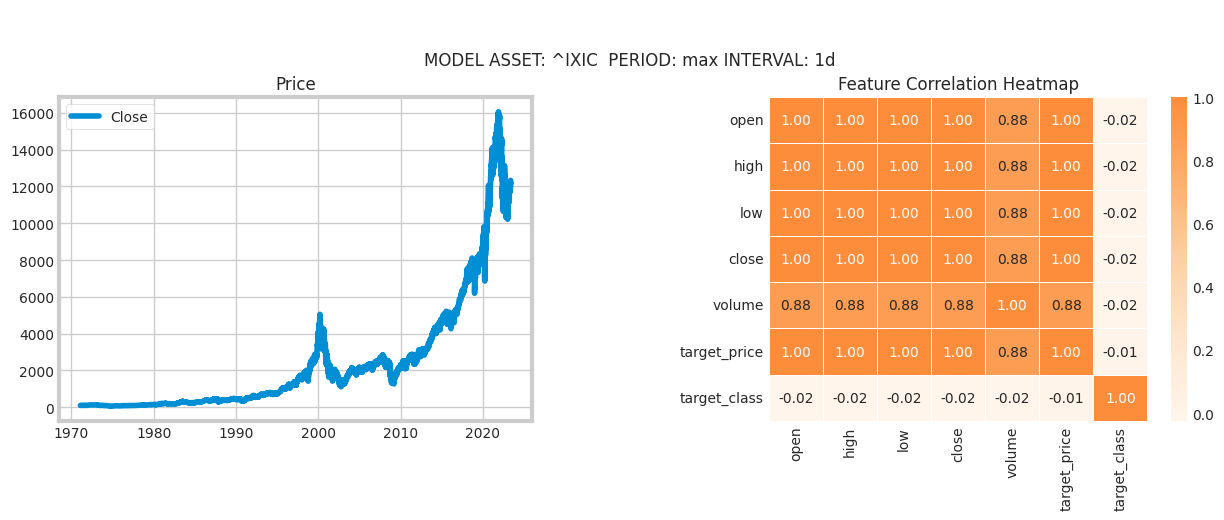

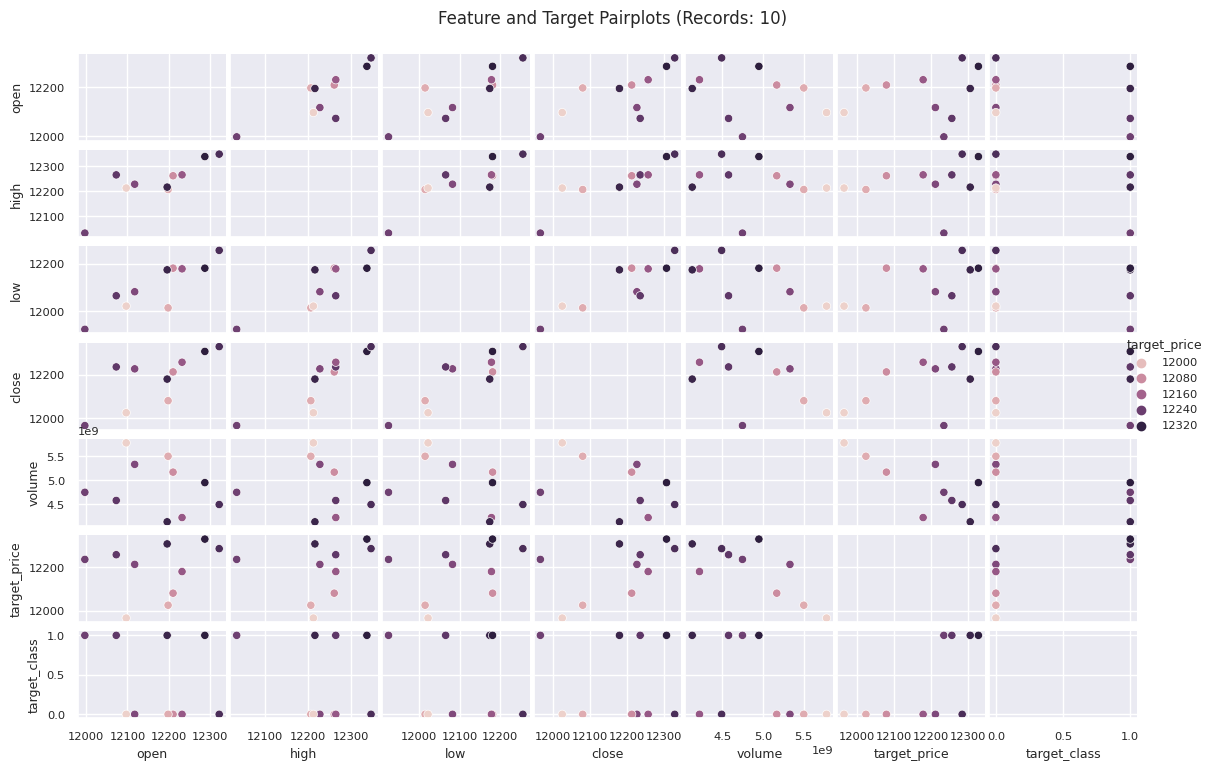

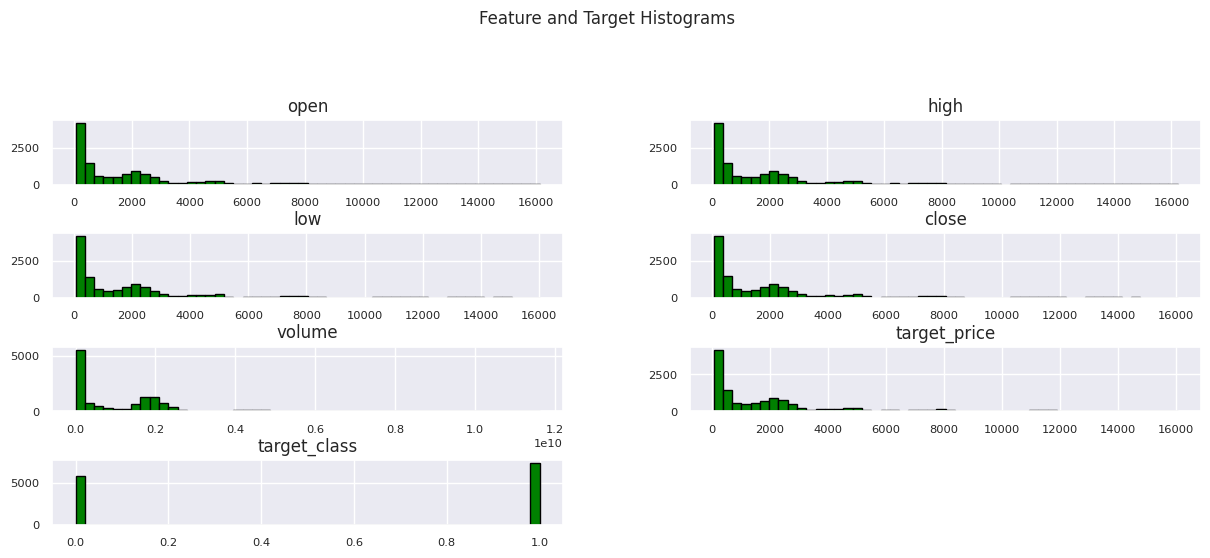

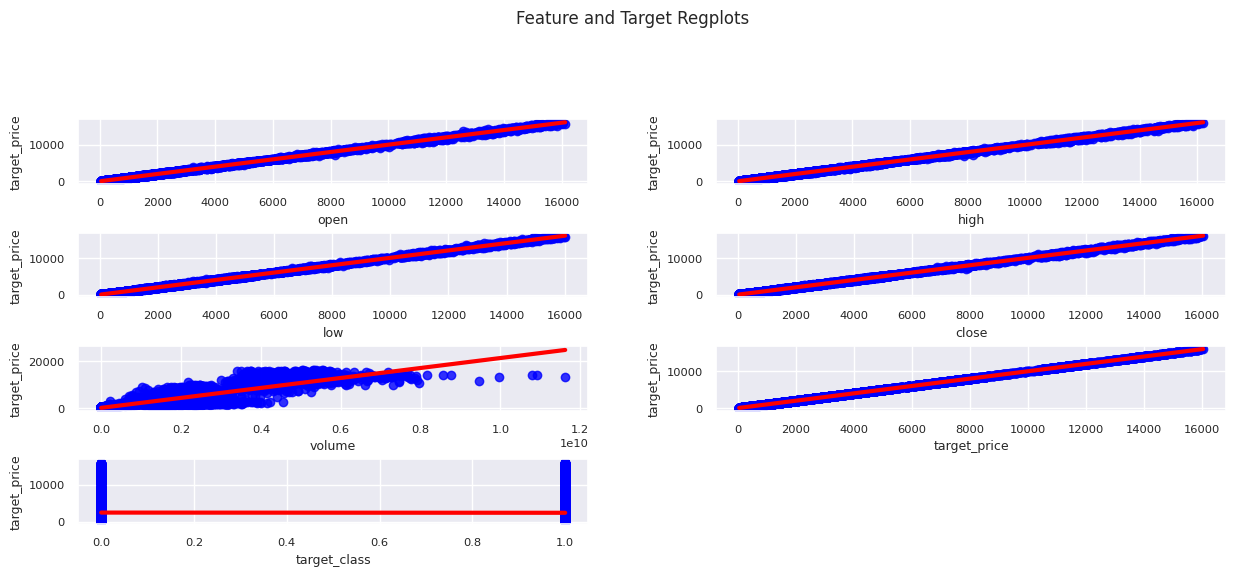

In [ ]:
AssetData(str_co_ticker_1).get_visual_data()

# Method run_class_model


 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           0       0.45      0.73      0.55      1782
           1       0.54      0.26      0.36      2173

    accuracy                           0.47      3955
   macro avg       0.49      0.50      0.45      3955
weighted avg       0.50      0.47      0.44      3955

 

Crosstab Confusion Matrix:
 
Predicted Classification  0     1  
Actual Classification              
0                         1293  489
1                         1598  575
 



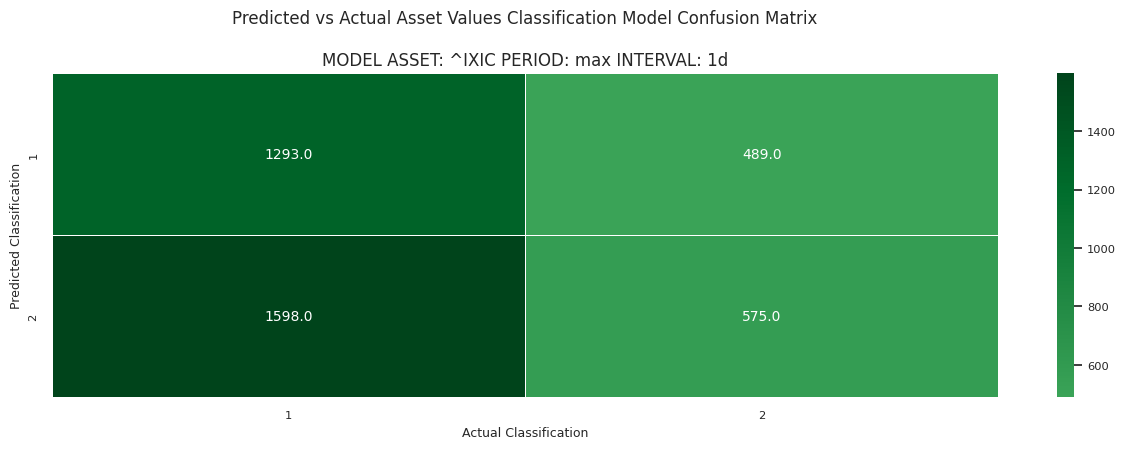


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume      target_class  target_pred
date                                                                                     
2023-04-28  12117.54  12227.72  12082.57  12226.58  5331380000  0             0          
2023-05-01  12210.05  12261.32  12181.08  12212.60  5168430000  0             0          
2023-05-02  12198.02  12206.58  12015.23  12080.51  5501410000  0             0          
2023-05-03  12097.04  12212.55  12022.46  12025.33  5782160000  0             0          
2023-05-04  11997.34  12033.15  11925.37  11966.40  4745780000  1             0          
2023-05-05  12073.03  12264.83  12065.72  12235.41  4574790000  1             0          
2023-05-08  12231.68  12264.99  12178.26  12256.92  4216360000  0             0          
2023-05-09  12195.78  12216.13  12174.06  12179.55  4126780000  1             0          
2023-05-10  12286.66  12337.69  12180.86  12306.44

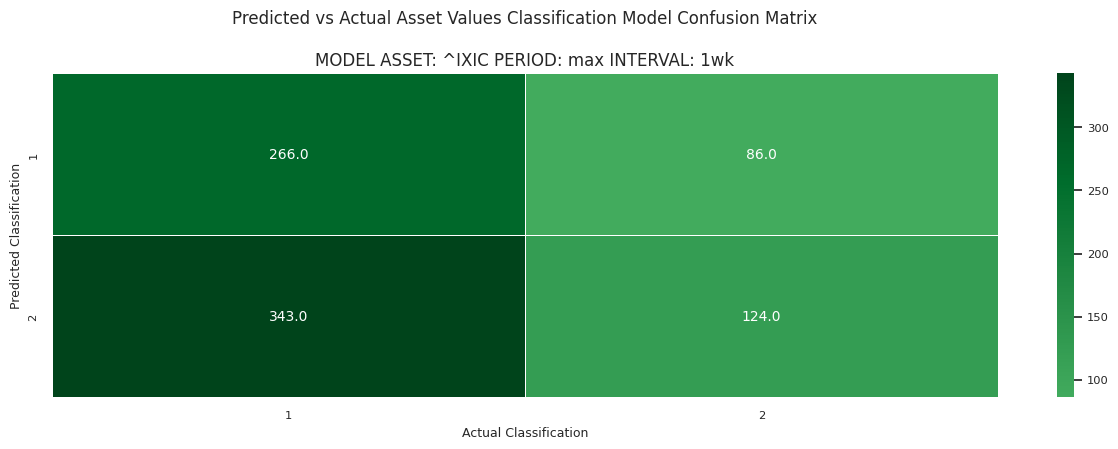


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume       target_class  target_pred
date                                                                                      
2023-02-27  11517.19  11699.63  11273.61  11689.01  25178450000  0             0          
2023-03-06  11736.87  11827.92  11093.86  11138.89  26746960000  1             0          
2023-03-13  11041.46  11773.11  10982.80  11630.51  31049050000  1             0          
2023-03-20  11614.39  12013.99  11550.69  11823.96  24063200000  1             0          
2023-03-27  11868.54  12227.93  11635.03  12221.91  23120800000  0             0          
2023-04-03  12146.09  12224.68  11898.36  12087.96  17356590000  1             0          
2023-04-10  11975.13  12205.72  11916.54  12123.47  23519530000  0             0          
2023-04-17  12108.23  12245.43  11986.82  12072.46  24106270000  1             0          
2023-04-24  12053.47  12227.72  11798.77

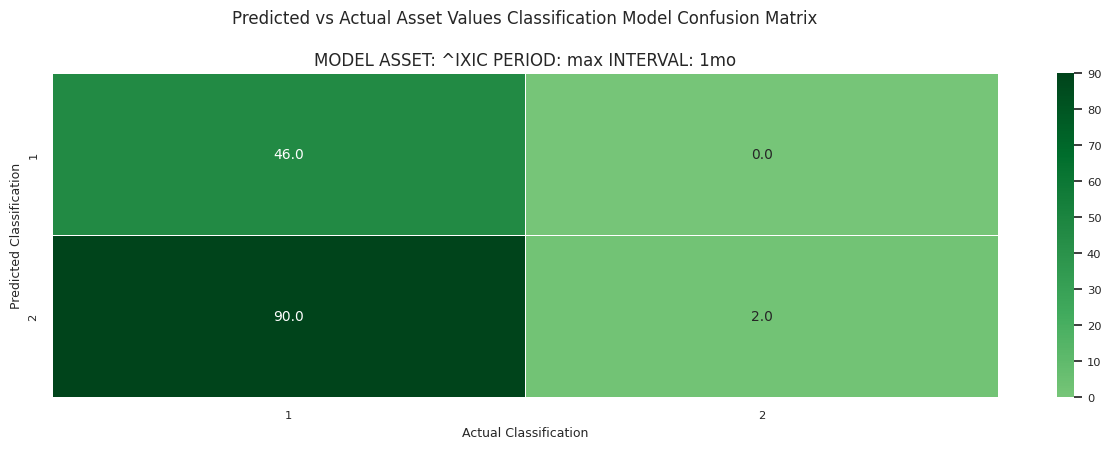


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume        target_class  target_pred
date                                                                                       
2022-07-01  11006.83  12426.26  10911.45  12390.69   94293720000  0             0          
2022-08-01  12317.96  13181.09  11790.02  11816.20  110367680000  0             0          
2022-09-01  11707.44  12270.19  10572.33  10575.62   98888530000  1             0          
2022-10-01  10659.01  11230.44  10088.83  10988.15   98292380000  1             0          
2022-11-01  11154.74  11492.62  10262.93  11468.00  101572370000  0             0          
2022-12-01  11475.17  11571.64  10207.47  10466.48  100007430000  1             0          
2023-01-01  10562.06  11691.89  10265.04  11584.55  106732920000  0             0          
2023-02-01  11573.14  12269.55  11334.47  11455.54   99644100000  1             0          
2023-03-01  11447.58  12227.93

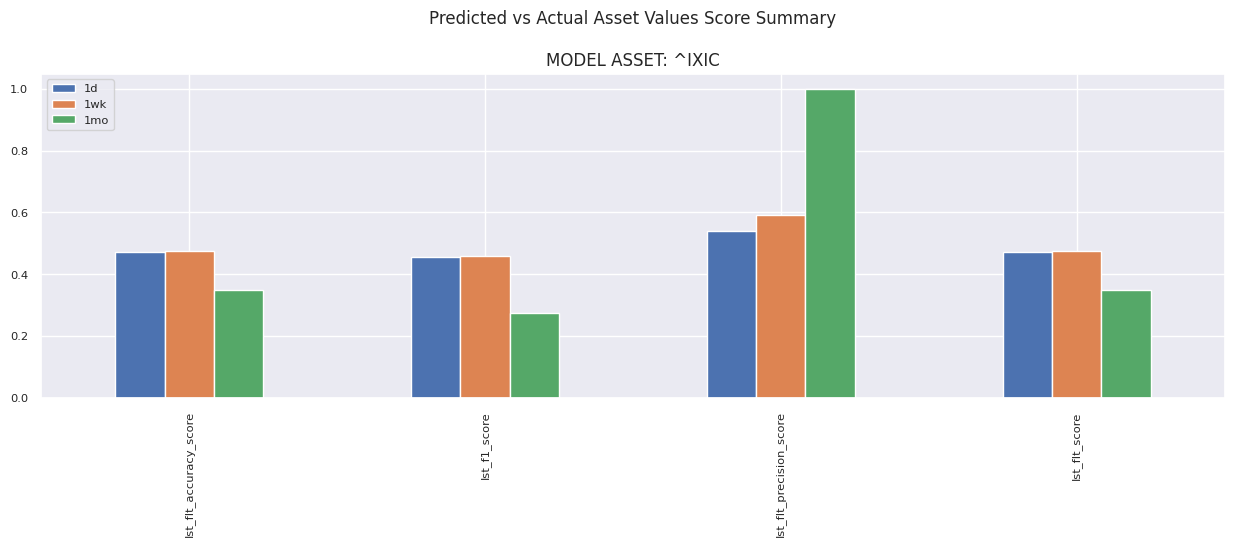

In [ ]:
AssetData(str_co_ticker_1).run_class_model()

# Method run_class_model_list


 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           0       0.45      0.73      0.55      1782
           1       0.54      0.26      0.36      2173

    accuracy                           0.47      3955
   macro avg       0.50      0.50      0.46      3955
weighted avg       0.50      0.47      0.45      3955

 

Crosstab Confusion Matrix:
 
Predicted Classification  0     1  
Actual Classification              
0                         1297  485
1                         1598  575
 



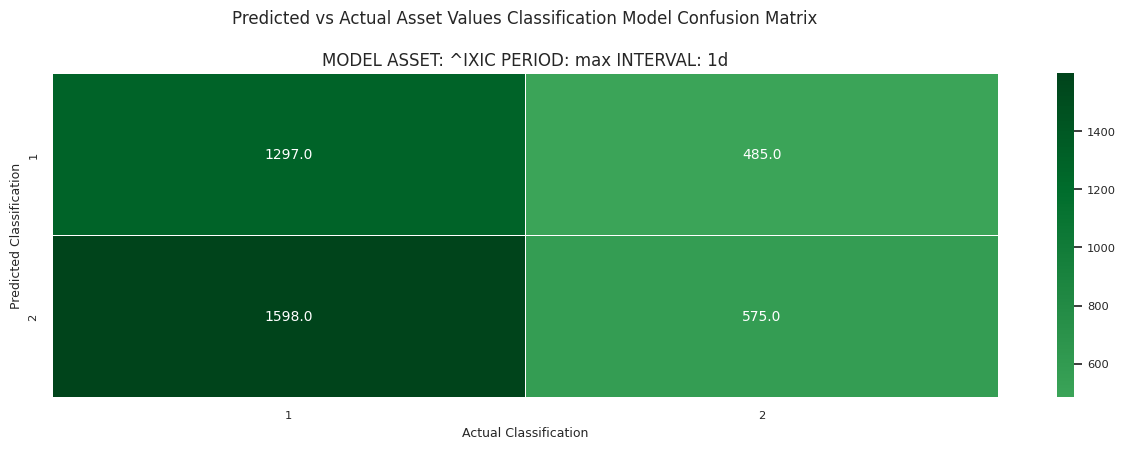


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume      target_class  target_pred
date                                                                                     
2023-04-28  12117.54  12227.72  12082.57  12226.58  5331380000  0             0          
2023-05-01  12210.05  12261.32  12181.08  12212.60  5168430000  0             0          
2023-05-02  12198.02  12206.58  12015.23  12080.51  5501410000  0             0          
2023-05-03  12097.04  12212.55  12022.46  12025.33  5782160000  0             0          
2023-05-04  11997.34  12033.15  11925.37  11966.40  4745780000  1             0          
2023-05-05  12073.03  12264.83  12065.72  12235.41  4574790000  1             0          
2023-05-08  12231.68  12264.99  12178.26  12256.92  4216360000  0             0          
2023-05-09  12195.78  12216.13  12174.06  12179.55  4126780000  1             0          
2023-05-10  12286.66  12337.69  12180.86  12306.44

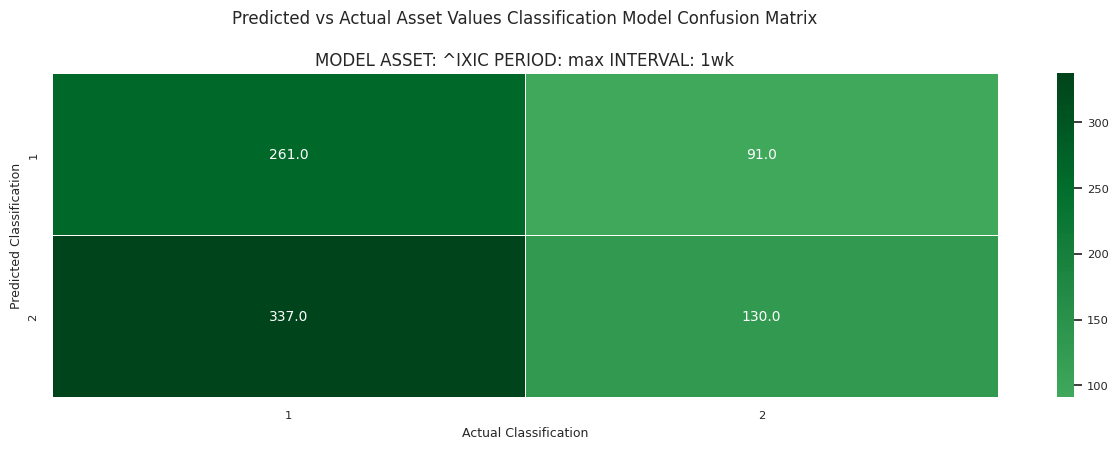


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume       target_class  target_pred
date                                                                                      
2023-02-27  11517.19  11699.63  11273.61  11689.01  25178450000  0             0          
2023-03-06  11736.87  11827.92  11093.86  11138.89  26746960000  1             0          
2023-03-13  11041.46  11773.11  10982.80  11630.51  31049050000  1             0          
2023-03-20  11614.39  12013.99  11550.69  11823.96  24063200000  1             0          
2023-03-27  11868.54  12227.93  11635.03  12221.91  23120800000  0             0          
2023-04-03  12146.09  12224.68  11898.36  12087.96  17356590000  1             0          
2023-04-10  11975.13  12205.72  11916.54  12123.47  23519530000  0             0          
2023-04-17  12108.23  12245.43  11986.82  12072.46  24106270000  1             0          
2023-04-24  12053.47  12227.72  11798.77

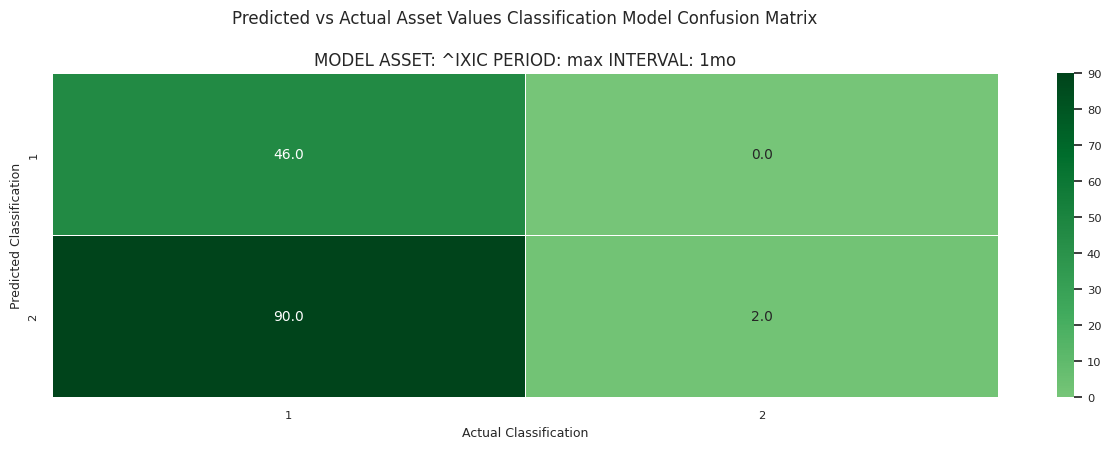


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume        target_class  target_pred
date                                                                                       
2022-07-01  11006.83  12426.26  10911.45  12390.69   94293720000  0             0          
2022-08-01  12317.96  13181.09  11790.02  11816.20  110367680000  0             0          
2022-09-01  11707.44  12270.19  10572.33  10575.62   98888530000  1             0          
2022-10-01  10659.01  11230.44  10088.83  10988.15   98292380000  1             0          
2022-11-01  11154.74  11492.62  10262.93  11468.00  101572370000  0             0          
2022-12-01  11475.17  11571.64  10207.47  10466.48  100007430000  1             0          
2023-01-01  10562.06  11691.89  10265.04  11584.55  106732920000  0             0          
2023-02-01  11573.14  12269.55  11334.47  11455.54   99644100000  1             0          
2023-03-01  11447.58  12227.93

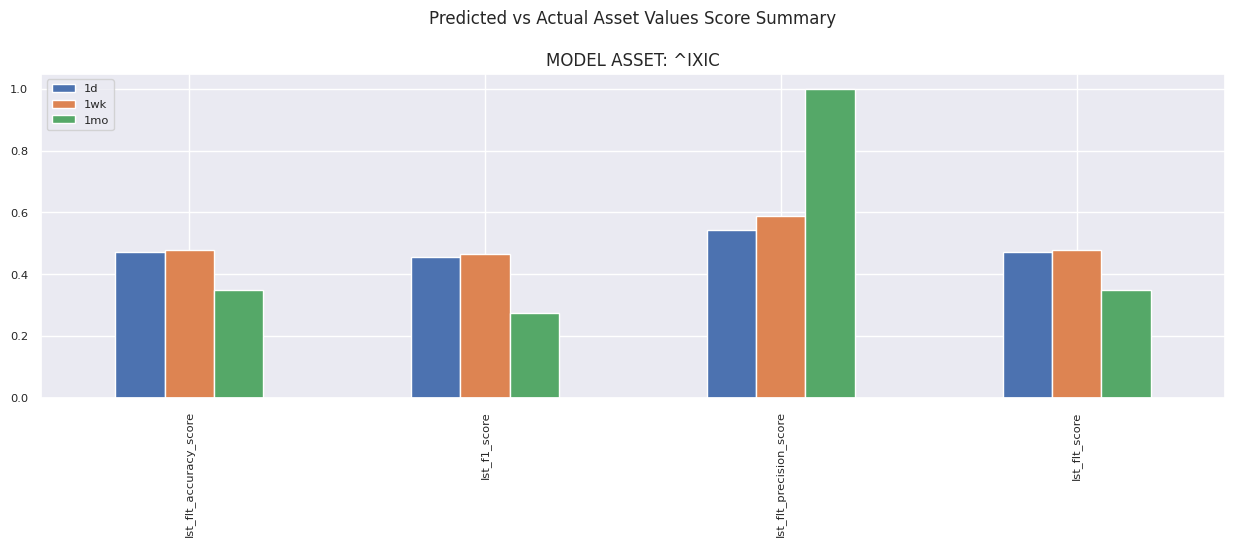


 

None

 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           0       0.50      0.80      0.61      2281
           1       0.53      0.21      0.30      2353

    accuracy                           0.50      4634
   macro avg       0.51      0.51      0.46      4634
weighted avg       0.51      0.50      0.46      4634

 

Crosstab Confusion Matrix:
 
Predicted Classification  0     1  
Actual Classification              
0                         1836  445
1                         1855  498
 



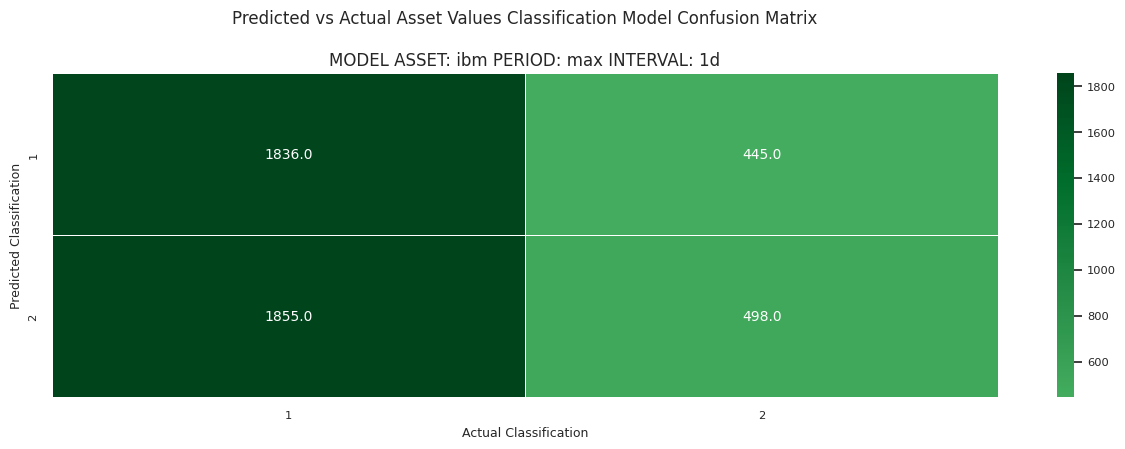


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume   target_class  target_pred
date                                                                          
2023-04-28  126.58  127.25  125.64  126.41  5060500  0             1          
2023-05-01  126.35  126.75  126.06  126.09  2725000  0             0          
2023-05-02  126.30  126.45  123.27  125.16  4445300  0             0          
2023-05-03  125.46  125.57  123.26  123.45  4554200  0             0          
2023-05-04  123.03  123.52  121.76  122.57  4468200  1             0          
2023-05-05  123.11  124.10  122.81  123.65  4970800  0             0          
2023-05-08  123.76  123.92  122.55  123.40  3663800  0             0          
2023-05-09  121.90  121.97  120.66  121.17  4540000  1             0          
2023-05-10  121.99  122.49  121.10  122.02  4189200  0             0          
2023-05-11  122.02  122.24  120.55  120.90  3446500  1             0          
 


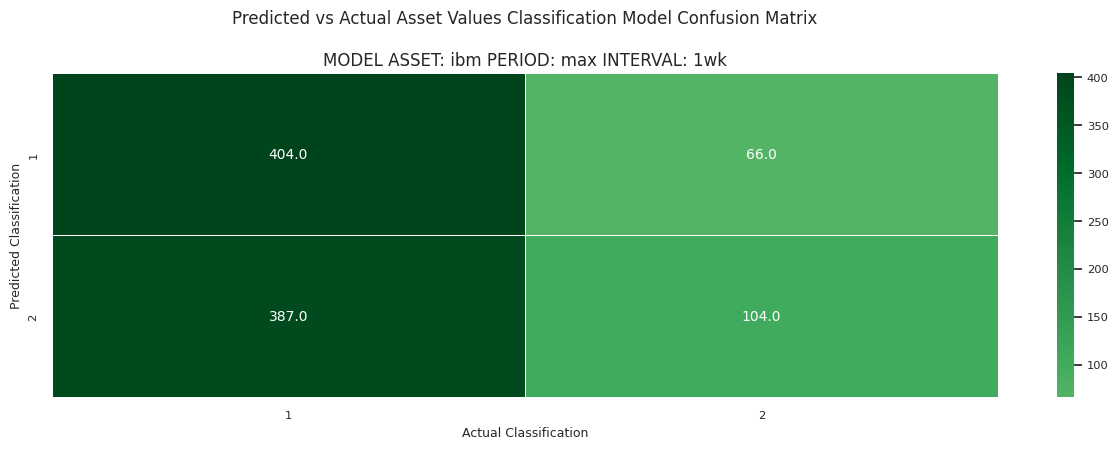


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume    target_class  target_pred
date                                                                           
2023-02-27  131.42  131.87  127.71  129.64  17865500  0             0          
2023-03-06  129.64  130.86  125.13  125.45  20909600  0             0          
2023-03-13  125.15  128.19  121.71  123.69  66131400  1             0          
2023-03-20  124.31  127.22  122.60  125.29  20457800  1             0          
2023-03-27  126.47  131.48  126.47  131.09  20779100  0             0          
2023-04-03  130.97  132.61  130.32  130.50  13172200  0             0          
2023-04-10  129.83  131.10  126.00  128.14  19506400  0             0          
2023-04-17  128.30  130.98  125.27  125.73  30345900  1             0          
2023-04-24  125.55  127.25  124.56  126.41  20654900  0             0          
2023-05-01  126.35  126.75  121.76  123.65  21163500  0             0 

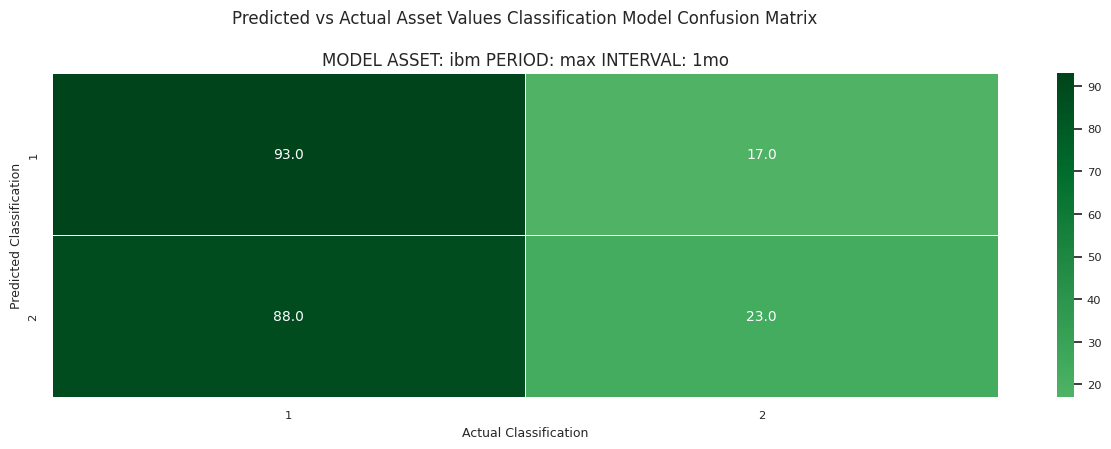


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_class  target_pred
date                                                                            
2022-07-01  141.00  141.87  125.13  130.79  129791800  0             0          
2022-08-01  130.75  139.34  128.40  128.45   77419800  0             0          
2022-09-01  128.40  130.99  118.61  118.81   87265100  1             0          
2022-10-01  120.16  138.86  115.55  138.29  113478200  1             0          
2022-11-01  138.25  150.46  133.97  148.90   93661300  0             0          
2022-12-01  149.98  153.21  137.20  140.89   86424100  0             0          
2023-01-01  141.10  147.18  132.98  134.73  105575000  0             0          
2023-02-01  134.49  137.39  128.86  129.30   76080200  1             0          
2023-03-01  128.90  131.48  121.71  131.09  138239000  0             0          
2023-04-01  130.97  132.61  124.56  126.41   83679400  0   

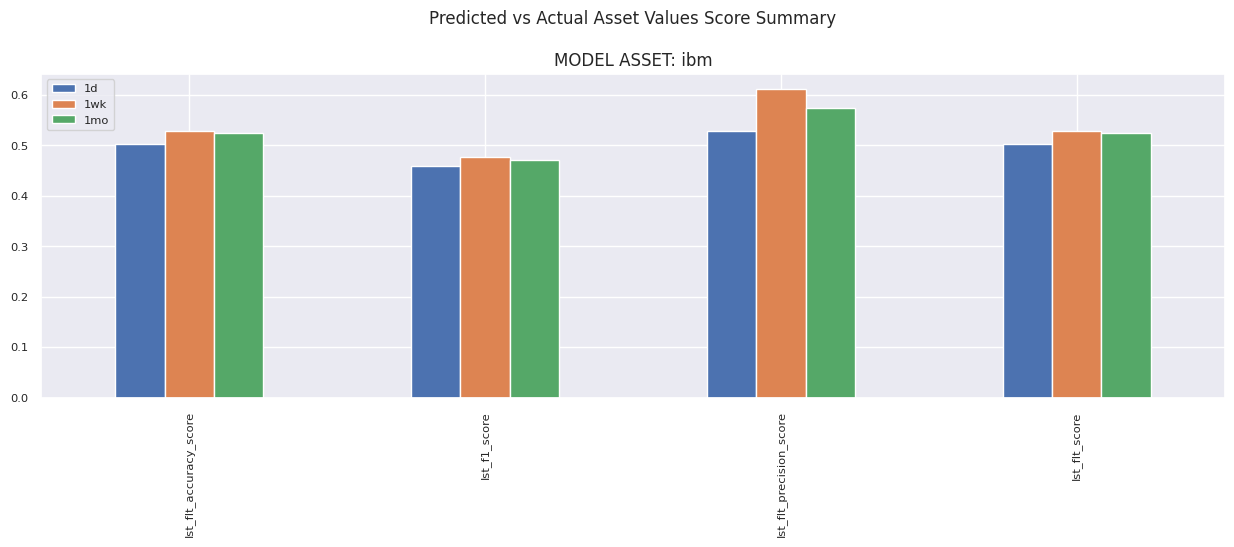


 

None

 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           0       0.45      0.73      0.56      1782
           1       0.54      0.26      0.35      2173

    accuracy                           0.47      3955
   macro avg       0.49      0.50      0.45      3955
weighted avg       0.50      0.47      0.44      3955

 

Crosstab Confusion Matrix:
 
Predicted Classification  0     1  
Actual Classification              
0                         1305  477
1                         1609  564
 



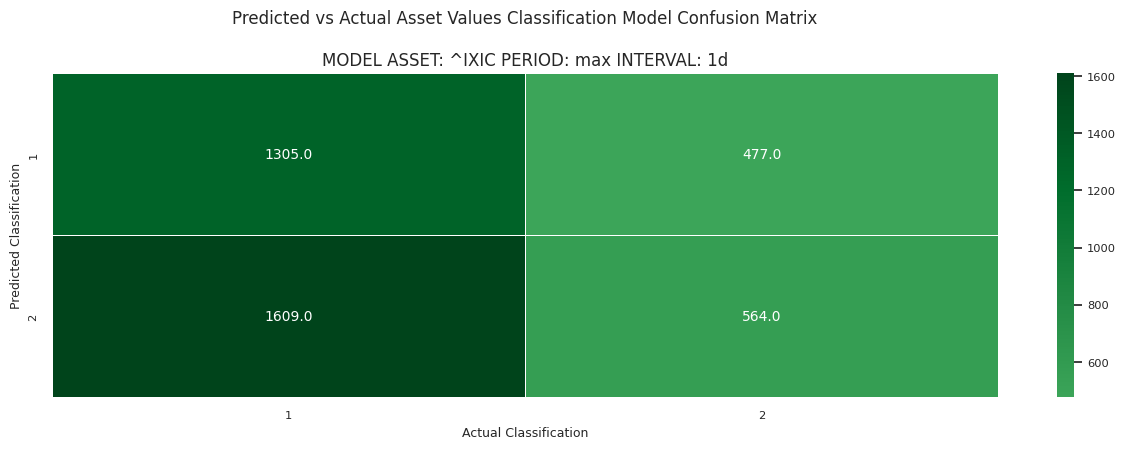


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume      target_class  target_pred
date                                                                                     
2023-04-28  12117.54  12227.72  12082.57  12226.58  5331380000  0             0          
2023-05-01  12210.05  12261.32  12181.08  12212.60  5168430000  0             0          
2023-05-02  12198.02  12206.58  12015.23  12080.51  5501410000  0             0          
2023-05-03  12097.04  12212.55  12022.46  12025.33  5782160000  0             0          
2023-05-04  11997.34  12033.15  11925.37  11966.40  4745780000  1             0          
2023-05-05  12073.03  12264.83  12065.72  12235.41  4574790000  1             0          
2023-05-08  12231.68  12264.99  12178.26  12256.92  4216360000  0             0          
2023-05-09  12195.78  12216.13  12174.06  12179.55  4126780000  1             0          
2023-05-10  12286.66  12337.69  12180.86  12306.44

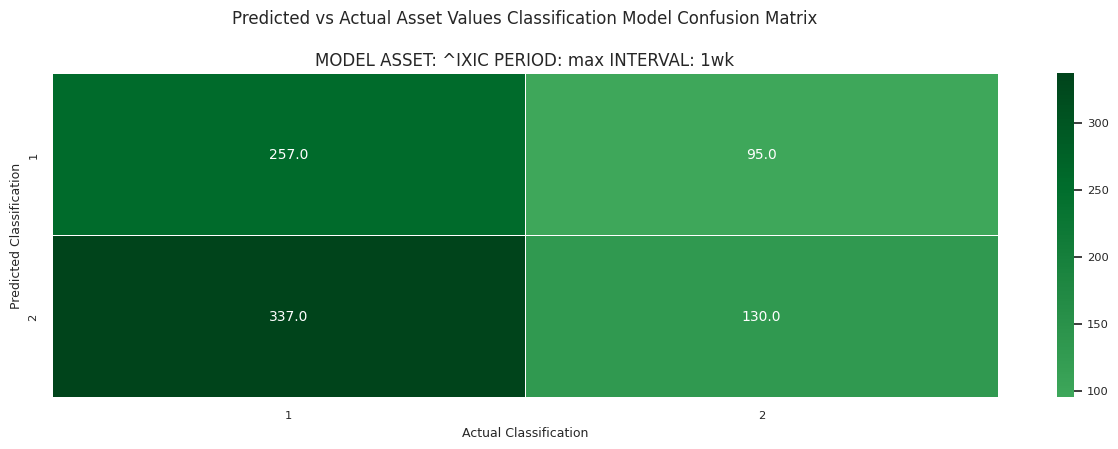


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume       target_class  target_pred
date                                                                                      
2023-02-27  11517.19  11699.63  11273.61  11689.01  25178450000  0             0          
2023-03-06  11736.87  11827.92  11093.86  11138.89  26746960000  1             0          
2023-03-13  11041.46  11773.11  10982.80  11630.51  31049050000  1             0          
2023-03-20  11614.39  12013.99  11550.69  11823.96  24063200000  1             0          
2023-03-27  11868.54  12227.93  11635.03  12221.91  23120800000  0             0          
2023-04-03  12146.09  12224.68  11898.36  12087.96  17356590000  1             0          
2023-04-10  11975.13  12205.72  11916.54  12123.47  23519530000  0             0          
2023-04-17  12108.23  12245.43  11986.82  12072.46  24106270000  1             0          
2023-04-24  12053.47  12227.72  11798.77

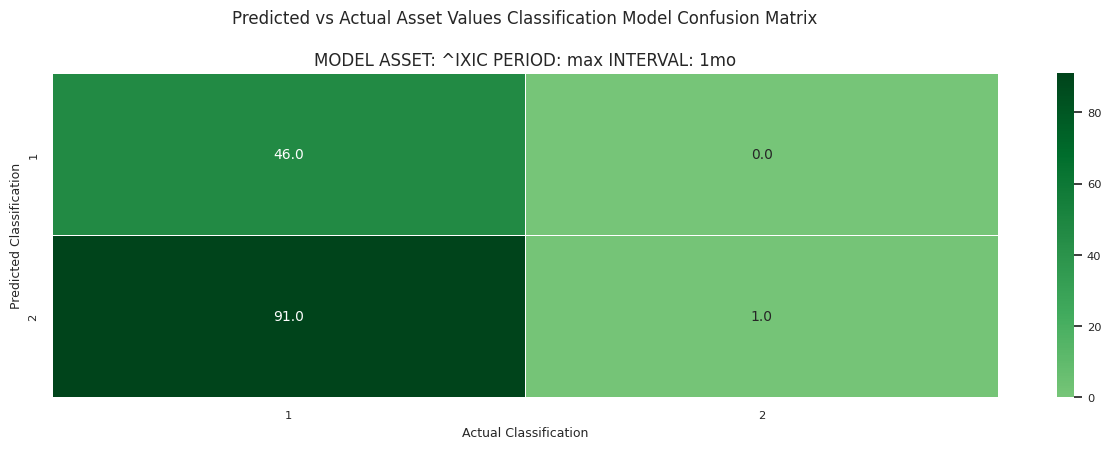


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume        target_class  target_pred
date                                                                                       
2022-07-01  11006.83  12426.26  10911.45  12390.69   94293720000  0             0          
2022-08-01  12317.96  13181.09  11790.02  11816.20  110367680000  0             0          
2022-09-01  11707.44  12270.19  10572.33  10575.62   98888530000  1             0          
2022-10-01  10659.01  11230.44  10088.83  10988.15   98292380000  1             0          
2022-11-01  11154.74  11492.62  10262.93  11468.00  101572370000  0             0          
2022-12-01  11475.17  11571.64  10207.47  10466.48  100007430000  1             0          
2023-01-01  10562.06  11691.89  10265.04  11584.55  106732920000  0             0          
2023-02-01  11573.14  12269.55  11334.47  11455.54   99644100000  1             0          
2023-03-01  11447.58  12227.93

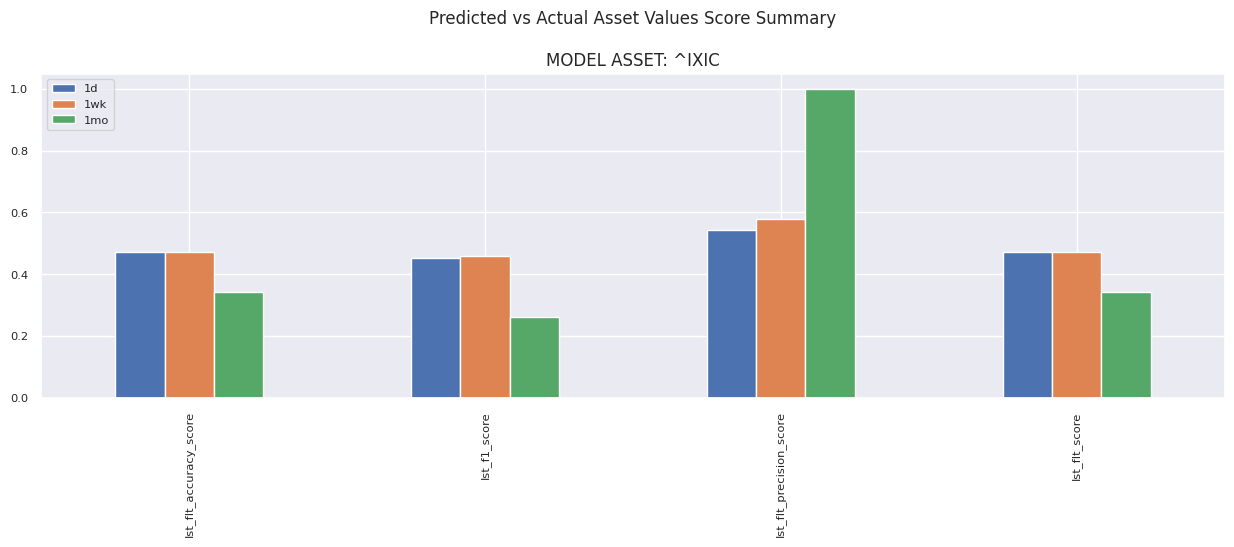


 

None


In [ ]:
AssetData(str_co_ticker_1).run_class_model_list([str_co_ticker_1, str_co_ticker_2])

# Method run_mlr_model


 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.13426541e-01  1.07705028e-01  5.48690528e-02  9.50080498e-01
  8.81197199e-11]
 

Model Intercept: 
 
0.5976362436800855
 



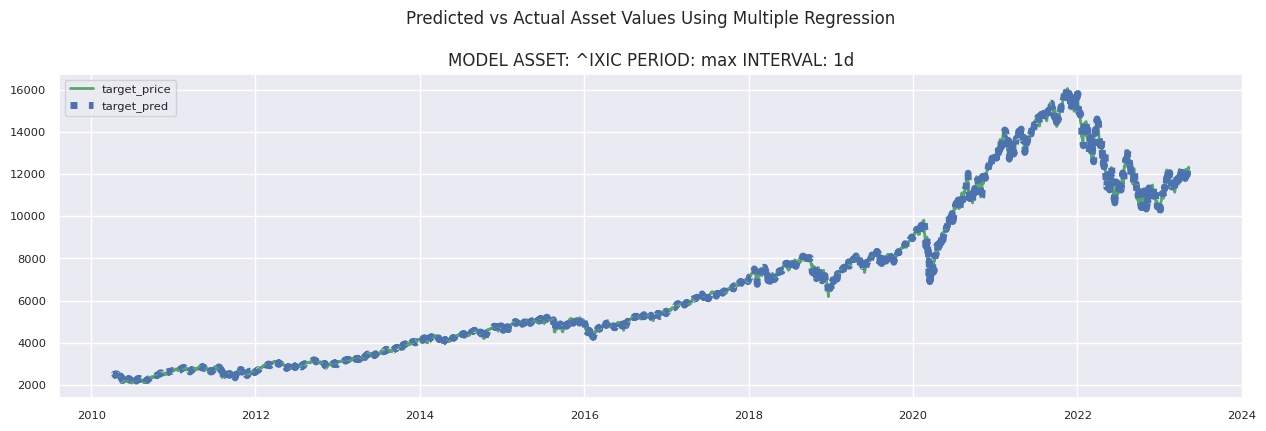


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume      target_price  target_pred
date                                                                                     
2023-04-28  12117.54  12227.72  12082.57  12226.58  5331380000  12212.60      12222.798  
2023-05-01  12210.05  12261.32  12181.08  12212.60  5168430000  12080.51      12208.032  
2023-05-02  12198.02  12206.58  12015.23  12080.51  5501410000  12025.33      12068.934  
2023-05-03  12097.04  12212.55  12022.46  12025.33  5782160000  11966.40      12029.027  
2023-05-04  11997.34  12033.15  11925.37  11966.40  4745780000  12235.41      11959.607  
2023-05-05  12073.03  12264.83  12065.72  12235.41  4574790000  12256.92      12239.242  
2023-05-08  12231.68  12264.99  12178.26  12256.92  4216360000  12179.55      12247.843  
2023-05-09  12195.78  12216.13  12174.06  12179.55  4126780000  12306.44      12172.907  
2023-05-10  12286.66  12337.69  12180.86  12306.44

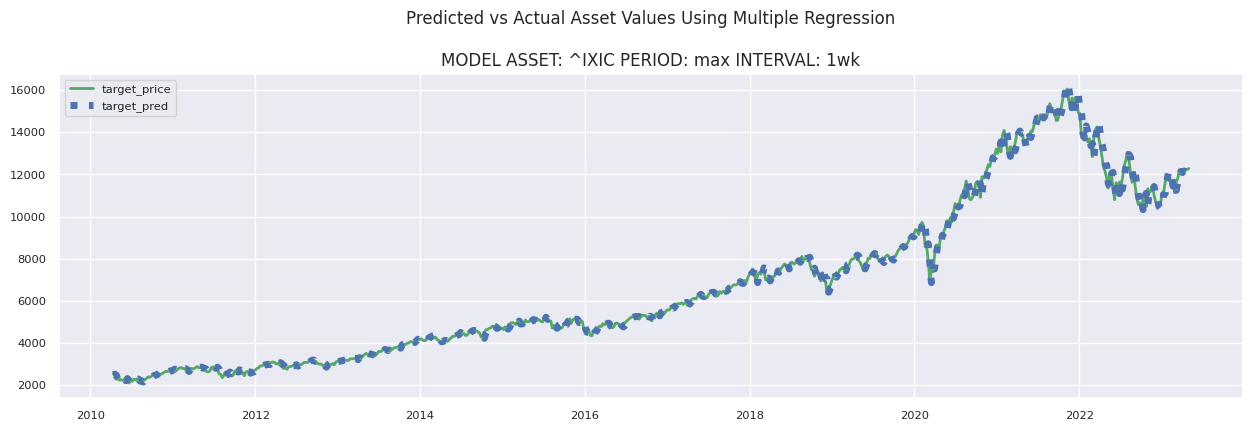


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume       target_price  target_pred
date                                                                                      
2023-02-27  11517.19  11699.63  11273.61  11689.01  25178450000  11138.890     11610.754  
2023-03-06  11736.87  11827.92  11093.86  11138.89  26746960000  11630.510     11244.547  
2023-03-13  11041.46  11773.11  10982.80  11630.51  31049050000  11823.960     11670.498  
2023-03-20  11614.39  12013.99  11550.69  11823.96  24063200000  12221.910     11911.234  
2023-03-27  11868.54  12227.93  11635.03  12221.91  23120800000  12087.960     12141.783  
2023-04-03  12146.09  12224.68  11898.36  12087.96  17356590000  12123.470     12089.844  
2023-04-10  11975.13  12205.72  11916.54  12123.47  23519530000  12072.460     12166.132  
2023-04-17  12108.23  12245.43  11986.82  12072.46  24106270000  12226.580     12139.251  
2023-04-24  12053.47  12227.72  11798.77

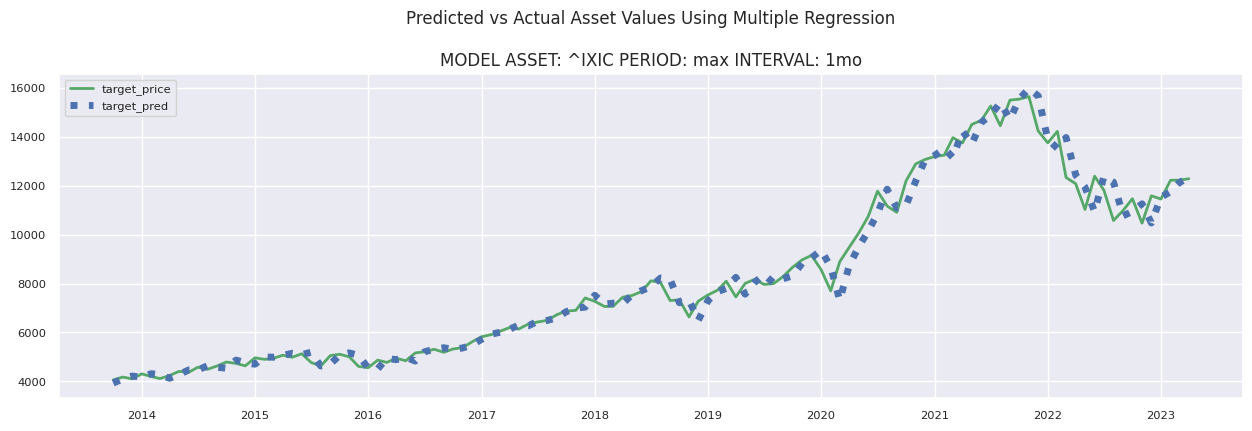


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume        target_price  target_pred
date                                                                                       
2022-07-01  11006.83  12426.26  10911.45  12390.69   94293720000  11816.200     12381.614  
2022-08-01  12317.96  13181.09  11790.02  11816.20  110367680000  10575.620     12143.597  
2022-09-01  11707.44  12270.19  10572.33  10575.62   98888530000  10988.150     10768.671  
2022-10-01  10659.01  11230.44  10088.83  10988.15   98292380000  11468.000     10947.343  
2022-11-01  11154.74  11492.62  10262.93  11468.00  101572370000  10466.480     11258.413  
2022-12-01  11475.17  11571.64  10207.47  10466.48  100007430000  11584.550     10477.045  
2023-01-01  10562.06  11691.89  10265.04  11584.55  106732920000  11455.540     11527.609  
2023-02-01  11573.14  12269.55  11334.47  11455.54   99644100000  12221.910     11754.890  
2023-03-01  11447.58  12227.93

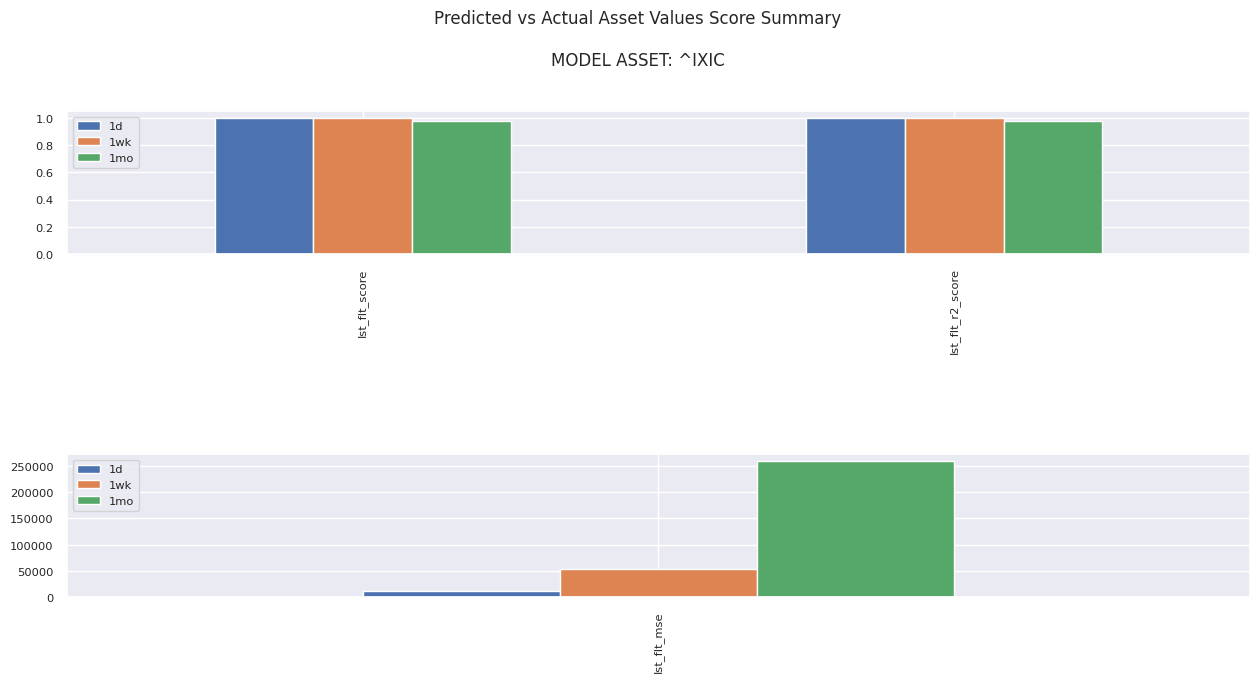

In [ ]:
AssetData(str_co_ticker_1).run_mlr_model()

# Method run_mlr_model_list


 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.13426541e-01  1.07705028e-01  5.48690528e-02  9.50080498e-01
  8.81197199e-11]
 

Model Intercept: 
 
0.5976362436800855
 



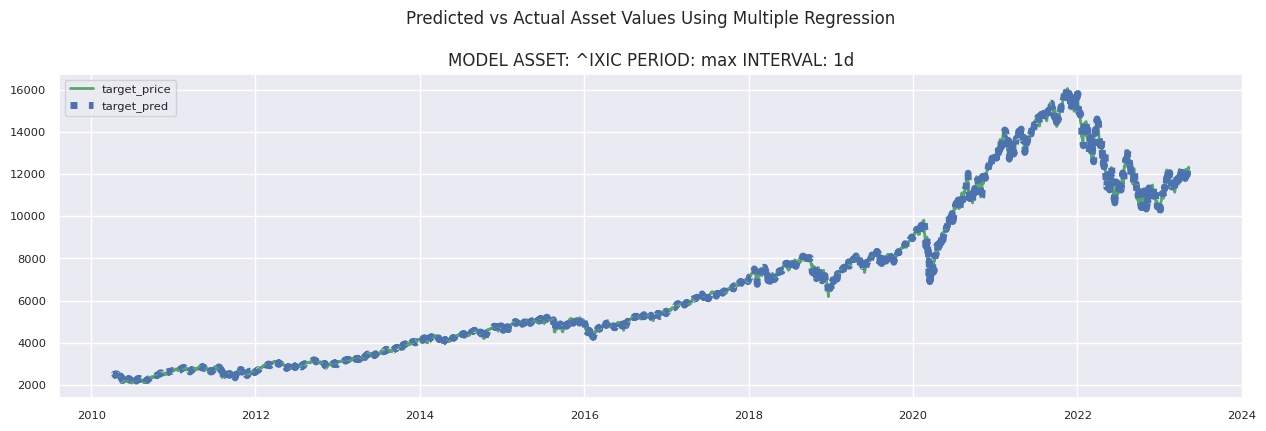


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume      target_price  target_pred
date                                                                                     
2023-04-28  12117.54  12227.72  12082.57  12226.58  5331380000  12212.60      12222.798  
2023-05-01  12210.05  12261.32  12181.08  12212.60  5168430000  12080.51      12208.032  
2023-05-02  12198.02  12206.58  12015.23  12080.51  5501410000  12025.33      12068.934  
2023-05-03  12097.04  12212.55  12022.46  12025.33  5782160000  11966.40      12029.027  
2023-05-04  11997.34  12033.15  11925.37  11966.40  4745780000  12235.41      11959.607  
2023-05-05  12073.03  12264.83  12065.72  12235.41  4574790000  12256.92      12239.242  
2023-05-08  12231.68  12264.99  12178.26  12256.92  4216360000  12179.55      12247.843  
2023-05-09  12195.78  12216.13  12174.06  12179.55  4126780000  12306.44      12172.907  
2023-05-10  12286.66  12337.69  12180.86  12306.44

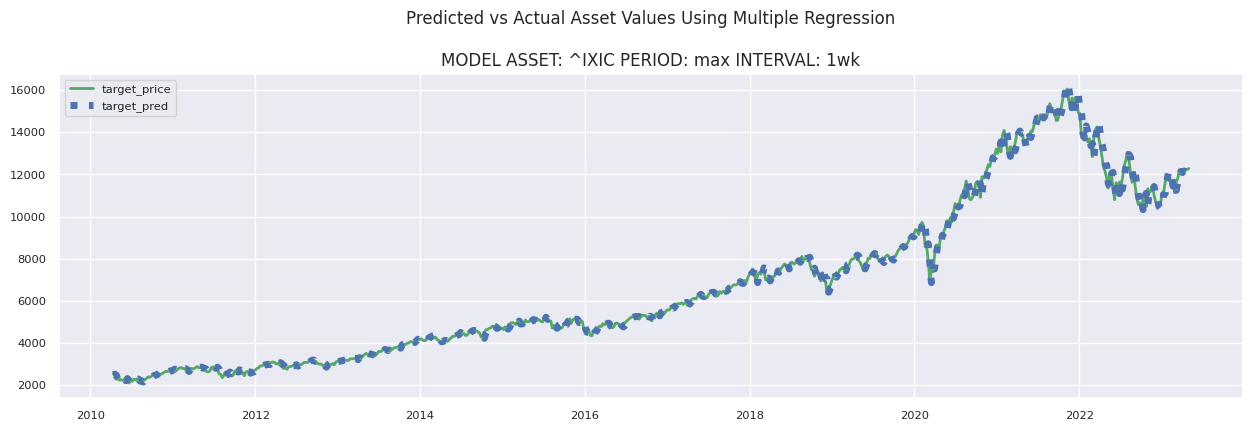


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume       target_price  target_pred
date                                                                                      
2023-02-27  11517.19  11699.63  11273.61  11689.01  25178450000  11138.890     11610.754  
2023-03-06  11736.87  11827.92  11093.86  11138.89  26746960000  11630.510     11244.547  
2023-03-13  11041.46  11773.11  10982.80  11630.51  31049050000  11823.960     11670.498  
2023-03-20  11614.39  12013.99  11550.69  11823.96  24063200000  12221.910     11911.234  
2023-03-27  11868.54  12227.93  11635.03  12221.91  23120800000  12087.960     12141.783  
2023-04-03  12146.09  12224.68  11898.36  12087.96  17356590000  12123.470     12089.844  
2023-04-10  11975.13  12205.72  11916.54  12123.47  23519530000  12072.460     12166.132  
2023-04-17  12108.23  12245.43  11986.82  12072.46  24106270000  12226.580     12139.251  
2023-04-24  12053.47  12227.72  11798.77

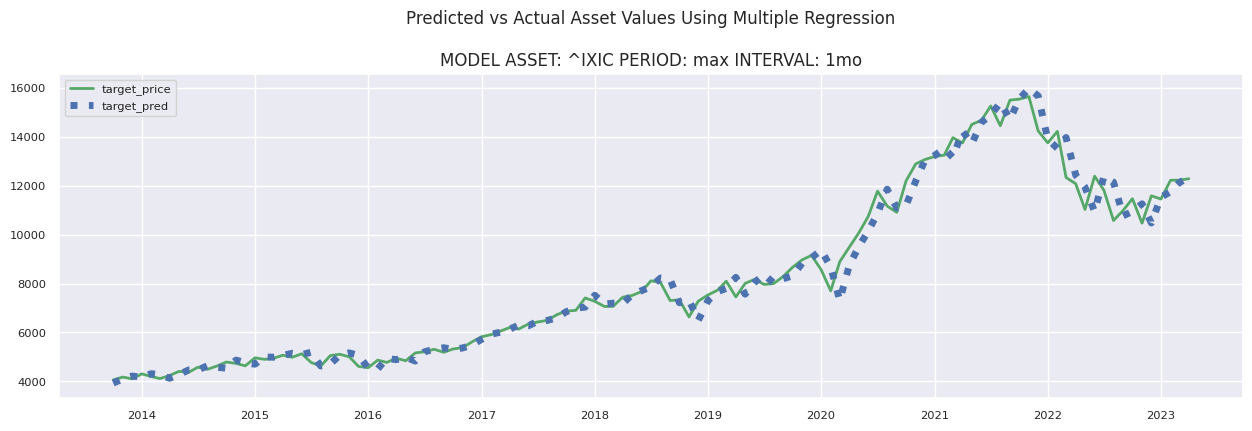


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume        target_price  target_pred
date                                                                                       
2022-07-01  11006.83  12426.26  10911.45  12390.69   94293720000  11816.200     12381.614  
2022-08-01  12317.96  13181.09  11790.02  11816.20  110367680000  10575.620     12143.597  
2022-09-01  11707.44  12270.19  10572.33  10575.62   98888530000  10988.150     10768.671  
2022-10-01  10659.01  11230.44  10088.83  10988.15   98292380000  11468.000     10947.343  
2022-11-01  11154.74  11492.62  10262.93  11468.00  101572370000  10466.480     11258.413  
2022-12-01  11475.17  11571.64  10207.47  10466.48  100007430000  11584.550     10477.045  
2023-01-01  10562.06  11691.89  10265.04  11584.55  106732920000  11455.540     11527.609  
2023-02-01  11573.14  12269.55  11334.47  11455.54   99644100000  12221.910     11754.890  
2023-03-01  11447.58  12227.93

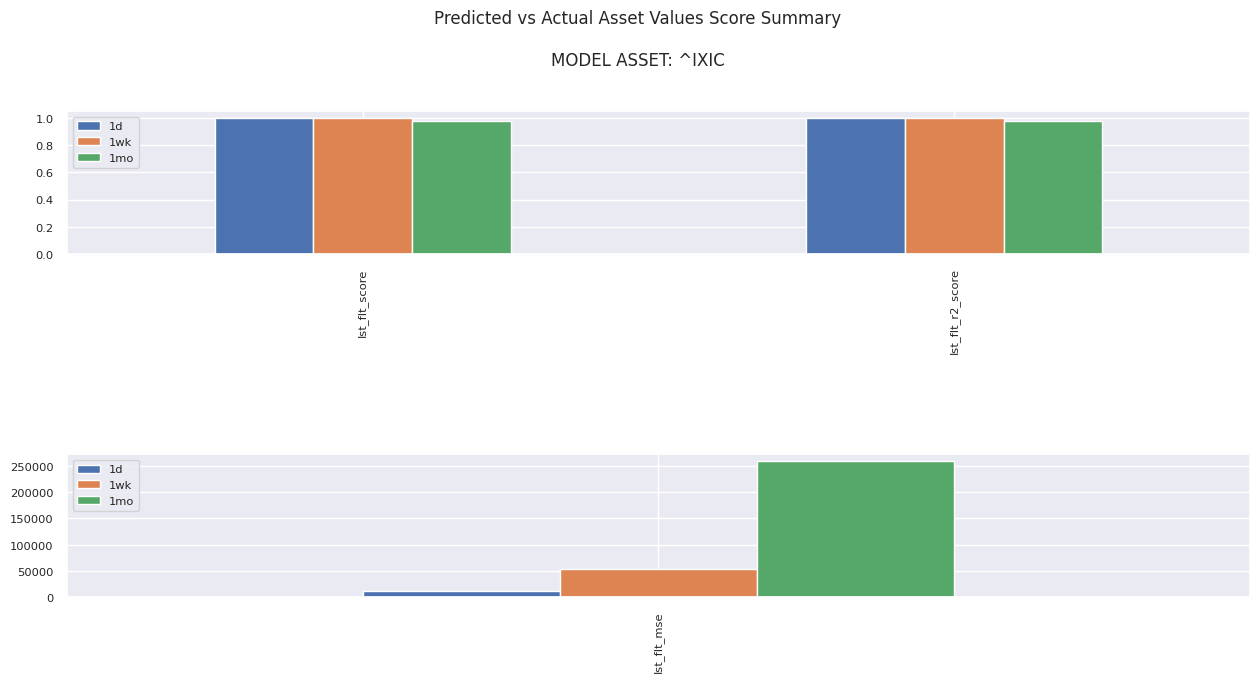


 

None

 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.53661447e-01  2.83996955e-01  1.61095533e-01  7.06494676e-01
  2.81287971e-09]
 

Model Intercept: 
 
0.018007284158755965
 



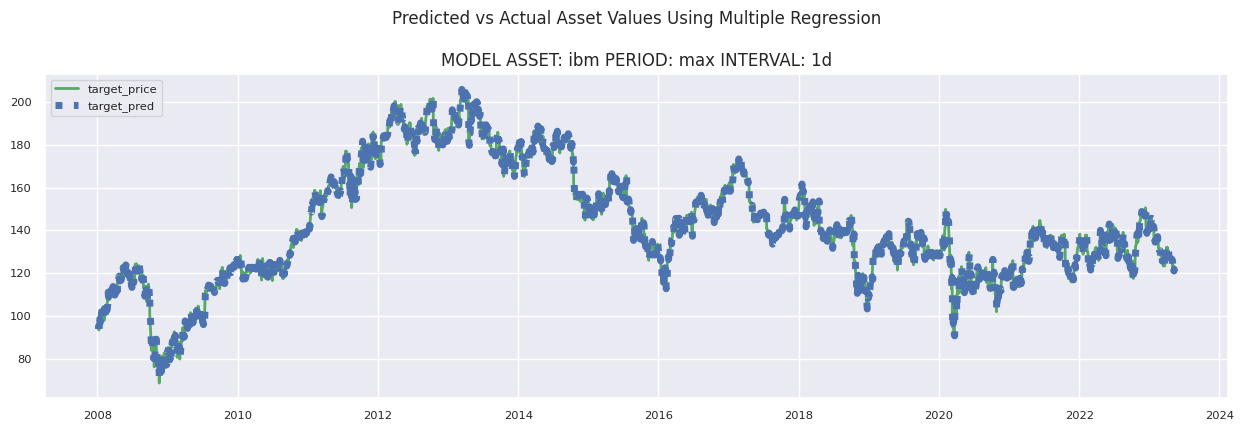


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume   target_price  target_pred
date                                                                          
2023-04-28  126.58  127.25  125.64  126.41  5060500  126.09        126.268    
2023-05-01  126.35  126.75  126.06  126.09  2725000  125.16        125.997    
2023-05-02  126.30  126.45  123.27  125.16  4445300  123.45        124.818    
2023-05-03  125.46  125.57  123.26  123.45  4554200  122.57        123.487    
2023-05-04  123.03  123.52  121.76  122.57  4468200  123.65        122.415    
2023-05-05  123.11  124.10  122.81  123.65  4970800  123.40        123.501    
2023-05-08  123.76  123.92  122.55  123.40  3663800  121.17        123.128    
2023-05-09  121.90  121.97  120.66  121.17  4540000  122.02        120.982    
2023-05-10  121.99  122.49  121.10  122.02  4189200  120.90        121.787    
2023-05-11  122.02  122.24  120.55  120.90  3446500  122.84        120.829    
 


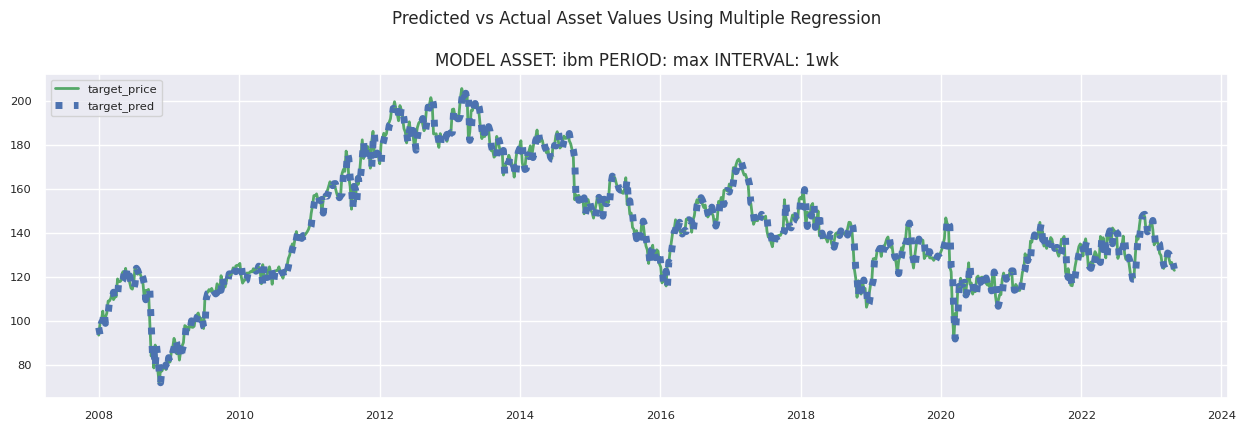


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume    target_price  target_pred
date                                                                           
2023-02-27  131.42  131.87  127.71  129.64  17865500  125.45        129.380    
2023-03-06  129.64  130.86  125.13  125.45  20909600  123.69        125.388    
2023-03-13  125.15  128.19  121.71  123.69  66131400  125.29        123.819    
2023-03-20  124.31  127.22  122.60  125.29  20457800  131.09        125.041    
2023-03-27  126.47  131.48  126.47  131.09  20779100  130.50        130.716    
2023-04-03  130.97  132.61  130.32  130.50  13172200  128.14        130.327    
2023-04-10  129.83  131.10  126.00  128.14  19506400  125.73        127.908    
2023-04-17  128.30  130.98  125.27  125.73  30345900  126.41        125.735    
2023-04-24  125.55  127.25  124.56  126.41  20654900  123.65        126.169    
2023-05-01  126.35  126.75  121.76  123.65  21163500  122.84        12

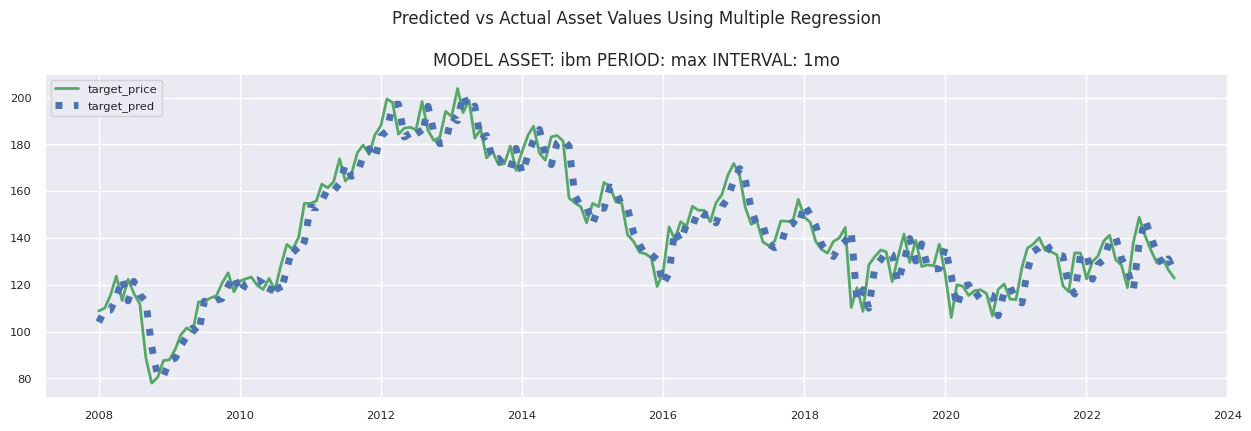


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_price  target_pred
date                                                                            
2022-07-01  141.00  141.87  125.13  130.79  129791800  128.45        131.354    
2022-08-01  130.75  139.34  128.40  128.45   77419800  118.81        126.239    
2022-09-01  128.40  130.99  118.61  118.81   87265100  138.29        118.056    
2022-10-01  120.16  138.86  115.55  138.29  113478200  148.90        137.870    
2022-11-01  138.25  150.46  133.97  148.90   93661300  140.89        147.910    
2022-12-01  149.98  153.21  137.20  140.89   86424100  134.73        140.383    
2023-01-01  141.10  147.18  132.98  134.73  105575000  129.30        133.499    
2023-02-01  134.49  137.39  128.86  129.30   76080200  131.09        127.925    
2023-03-01  128.90  131.48  121.71  131.09  138239000  126.41        131.104    
2023-04-01  130.97  132.61  124.56  126.41   83679400  122.

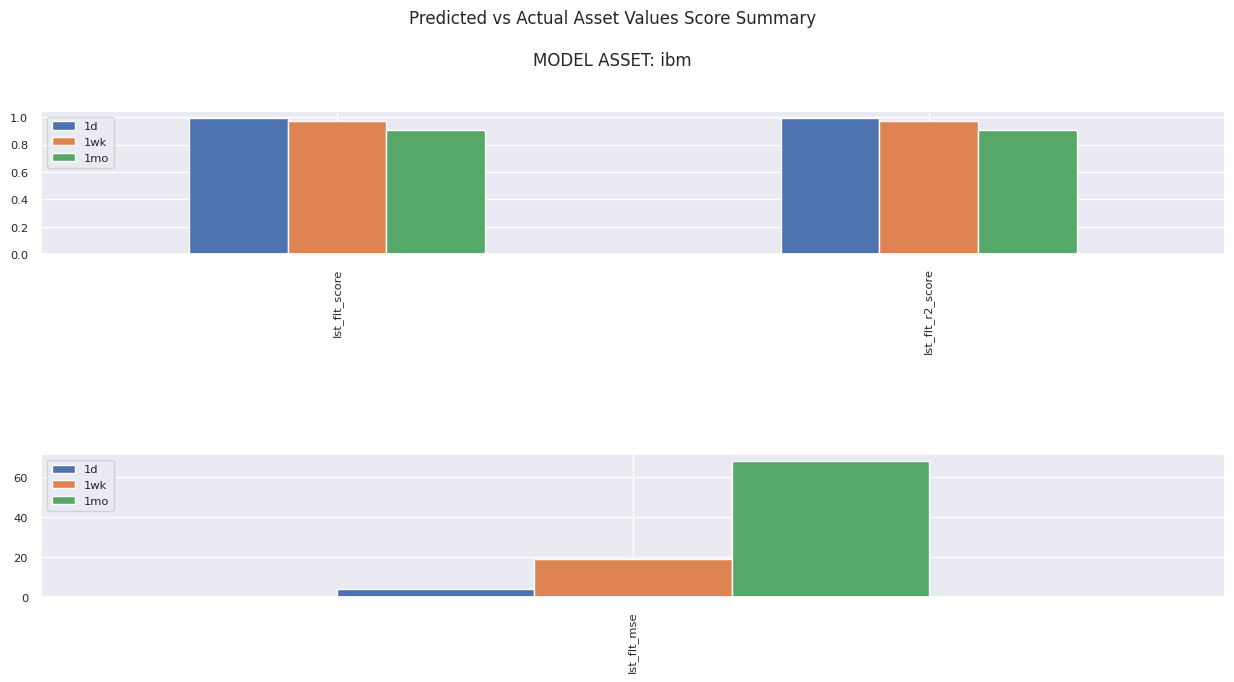


 

None

 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.13426541e-01  1.07705028e-01  5.48690528e-02  9.50080498e-01
  8.81197199e-11]
 

Model Intercept: 
 
0.5976362436800855
 



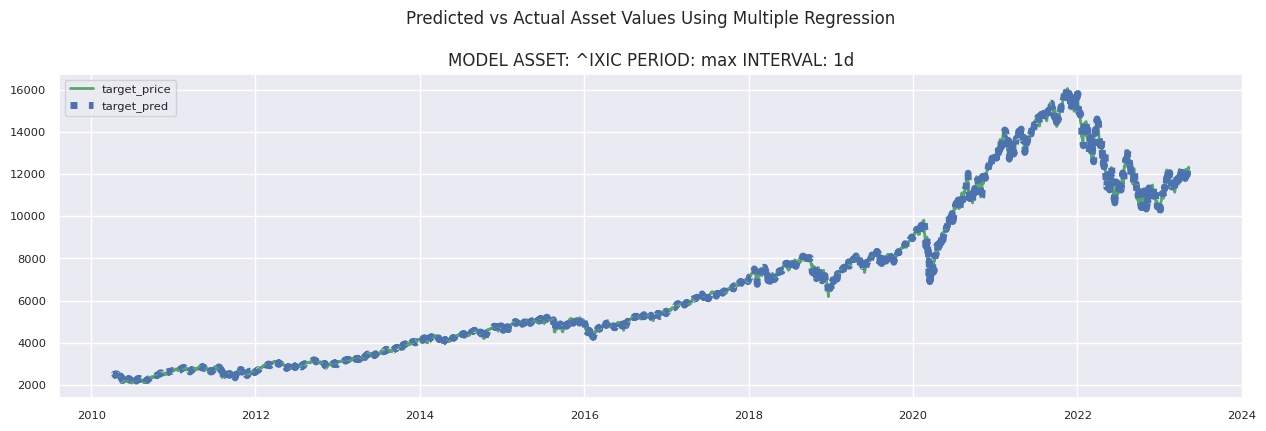


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume      target_price  target_pred
date                                                                                     
2023-04-28  12117.54  12227.72  12082.57  12226.58  5331380000  12212.60      12222.798  
2023-05-01  12210.05  12261.32  12181.08  12212.60  5168430000  12080.51      12208.032  
2023-05-02  12198.02  12206.58  12015.23  12080.51  5501410000  12025.33      12068.934  
2023-05-03  12097.04  12212.55  12022.46  12025.33  5782160000  11966.40      12029.027  
2023-05-04  11997.34  12033.15  11925.37  11966.40  4745780000  12235.41      11959.607  
2023-05-05  12073.03  12264.83  12065.72  12235.41  4574790000  12256.92      12239.242  
2023-05-08  12231.68  12264.99  12178.26  12256.92  4216360000  12179.55      12247.843  
2023-05-09  12195.78  12216.13  12174.06  12179.55  4126780000  12306.44      12172.907  
2023-05-10  12286.66  12337.69  12180.86  12306.44

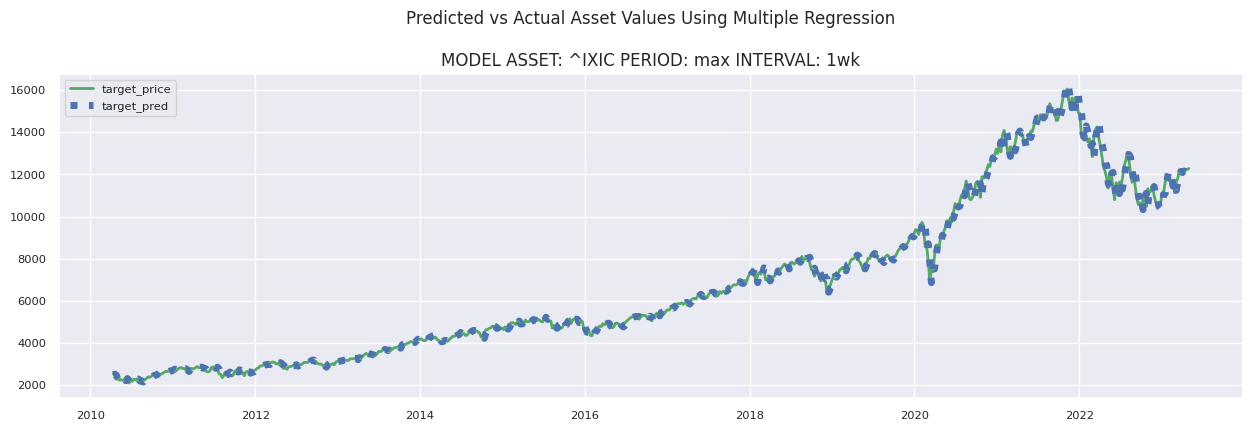


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume       target_price  target_pred
date                                                                                      
2023-02-27  11517.19  11699.63  11273.61  11689.01  25178450000  11138.890     11610.754  
2023-03-06  11736.87  11827.92  11093.86  11138.89  26746960000  11630.510     11244.547  
2023-03-13  11041.46  11773.11  10982.80  11630.51  31049050000  11823.960     11670.498  
2023-03-20  11614.39  12013.99  11550.69  11823.96  24063200000  12221.910     11911.234  
2023-03-27  11868.54  12227.93  11635.03  12221.91  23120800000  12087.960     12141.783  
2023-04-03  12146.09  12224.68  11898.36  12087.96  17356590000  12123.470     12089.844  
2023-04-10  11975.13  12205.72  11916.54  12123.47  23519530000  12072.460     12166.132  
2023-04-17  12108.23  12245.43  11986.82  12072.46  24106270000  12226.580     12139.251  
2023-04-24  12053.47  12227.72  11798.77

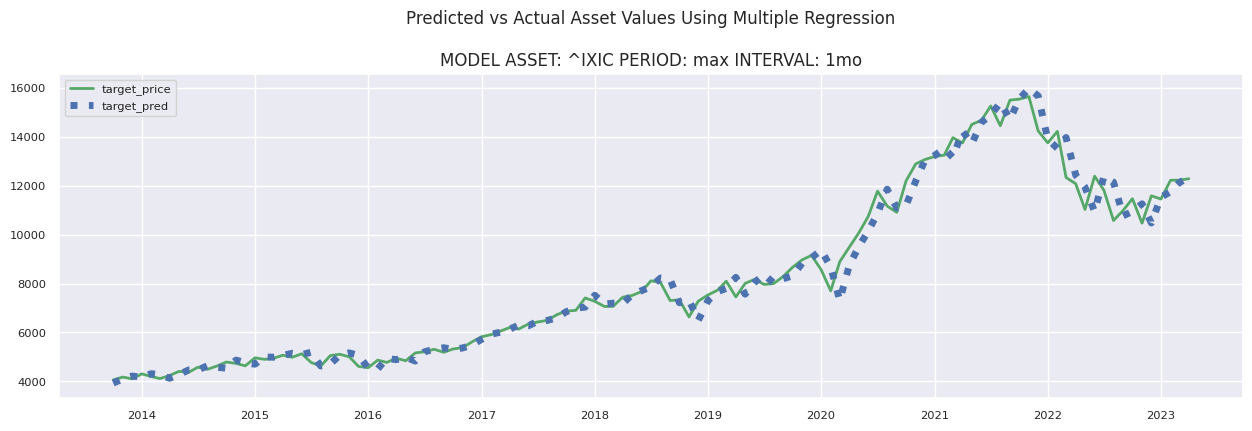


 

Feature, Target and Prediction Comparison: 
 
            open      high      low       close     volume        target_price  target_pred
date                                                                                       
2022-07-01  11006.83  12426.26  10911.45  12390.69   94293720000  11816.200     12381.614  
2022-08-01  12317.96  13181.09  11790.02  11816.20  110367680000  10575.620     12143.597  
2022-09-01  11707.44  12270.19  10572.33  10575.62   98888530000  10988.150     10768.671  
2022-10-01  10659.01  11230.44  10088.83  10988.15   98292380000  11468.000     10947.343  
2022-11-01  11154.74  11492.62  10262.93  11468.00  101572370000  10466.480     11258.413  
2022-12-01  11475.17  11571.64  10207.47  10466.48  100007430000  11584.550     10477.045  
2023-01-01  10562.06  11691.89  10265.04  11584.55  106732920000  11455.540     11527.609  
2023-02-01  11573.14  12269.55  11334.47  11455.54   99644100000  12221.910     11754.890  
2023-03-01  11447.58  12227.93

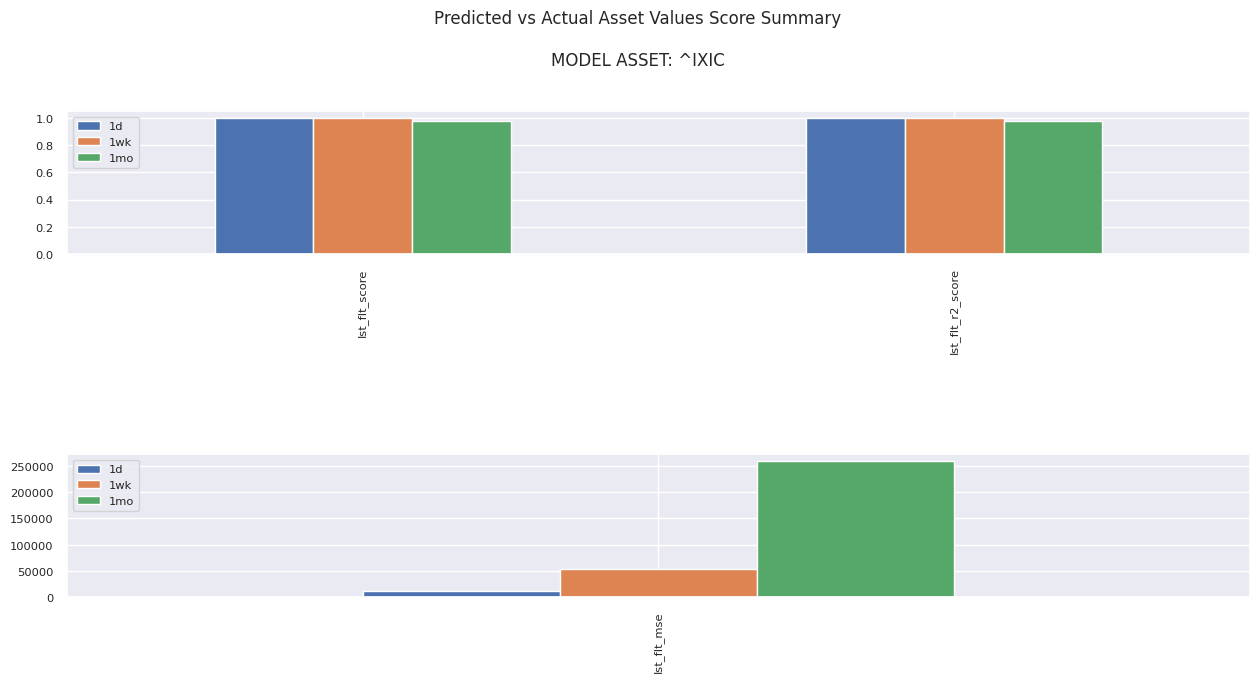


 

None


In [ ]:
AssetData(str_co_ticker_1).run_mlr_model_list([str_co_ticker_1, str_co_ticker_2])